# **New York City Yellow Taxi Data**

## Objective
In this case study you will be learning exploratory data analysis (EDA) with the help of a dataset on yellow taxi rides in New York City. This will enable you to understand why EDA is an important step in the process of data science and machine learning.

## **Problem Statement**
As an analyst at an upcoming taxi operation in NYC, you are tasked to use the 2023 taxi trip data to uncover insights that could help optimise taxi operations. The goal is to analyse patterns in the data that can inform strategic decisions to improve service efficiency, maximise revenue, and enhance passenger experience.

## Tasks
You need to perform the following steps for successfully completing this assignment:
1. Data Loading
2. Data Cleaning
3. Exploratory Analysis: Bivariate and Multivariate
4. Creating Visualisations to Support the Analysis
5. Deriving Insights and Stating Conclusions

---

**NOTE:** The marks given along with headings and sub-headings are cumulative marks for those particular headings/sub-headings.<br>

The actual marks for each task are specified within the tasks themselves.

For example, marks given with heading *2* or sub-heading *2.1* are the cumulative marks, for your reference only. <br>

The marks you will receive for completing tasks are given with the tasks.

Suppose the marks for two tasks are: 3 marks for 2.1.1 and 2 marks for 3.2.2, or
* 2.1.1 [3 marks]
* 3.2.2 [2 marks]

then, you will earn 3 marks for completing task 2.1.1 and 2 marks for completing task 3.2.2.


---

## Data Understanding
The yellow taxi trip records include fields capturing pick-up and drop-off dates/times, pick-up and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts.

The data is stored in Parquet format (*.parquet*). The dataset is from 2009 to 2024. However, for this assignment, we will only be using the data from 2023.

The data for each month is present in a different parquet file. You will get twelve files for each of the months in 2023.

The data was collected and provided to the NYC Taxi and Limousine Commission (TLC) by technology providers like vendors and taxi hailing apps. <br>

You can find the link to the TLC trip records page here: https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

###  Data Description
You can find the data description here: [Data Dictionary](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf)

**Trip Records**



|Field Name       |description |
|:----------------|:-----------|
| VendorID | A code indicating the TPEP provider that provided the record. <br> 1= Creative Mobile Technologies, LLC; <br> 2= VeriFone Inc. |
| tpep_pickup_datetime | The date and time when the meter was engaged.  |
| tpep_dropoff_datetime | The date and time when the meter was disengaged.   |
| Passenger_count | The number of passengers in the vehicle. <br> This is a driver-entered value. |
| Trip_distance | The elapsed trip distance in miles reported by the taximeter. |
| PULocationID | TLC Taxi Zone in which the taximeter was engaged |
| DOLocationID | TLC Taxi Zone in which the taximeter was disengaged |
|RateCodeID |The final rate code in effect at the end of the trip.<br> 1 = Standard rate <br> 2 = JFK <br> 3 = Newark <br>4 = Nassau or Westchester <br>5 = Negotiated fare <br>6 = Group ride |
|Store_and_fwd_flag |This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server.  <br>Y= store and forward trip <br>N= not a store and forward trip |
|Payment_type| A numeric code signifying how the passenger paid for the trip. <br> 1 = Credit card <br>2 = Cash <br>3 = No charge <br>4 = Dispute <br>5 = Unknown <br>6 = Voided trip |
|Fare_amount| The time-and-distance fare calculated by the meter. <br>Extra Miscellaneous extras and surcharges.  Currently, this only includes the 0.50 and 1 USD rush hour and overnight charges. |
|MTA_tax |0.50 USD MTA tax that is automatically triggered based on the metered rate in use. |
|Improvement_surcharge | 0.30 USD improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015. |
|Tip_amount |Tip amount – This field is automatically populated for credit card tips. Cash tips are not included. |
| Tolls_amount | Total amount of all tolls paid in trip.  |
| total_amount | The total amount charged to passengers. Does not include cash tips. |
|Congestion_Surcharge |Total amount collected in trip for NYS congestion surcharge. |
| Airport_fee | 1.25 USD for pick up only at LaGuardia and John F. Kennedy Airports|

Although the amounts of extra charges and taxes applied are specified in the data dictionary, you will see that some cases have different values of these charges in the actual data.

**Taxi Zones**

Each of the trip records contains a field corresponding to the location of the pickup or drop-off of the trip, populated by numbers ranging from 1-263.

These numbers correspond to taxi zones, which may be downloaded as a table or map/shapefile and matched to the trip records using a join.

This is covered in more detail in later sections.

---

## **1** Data Preparation

<font color = red>[5 marks]</font> <br>

### Import Libraries

In [186]:
# Import warnings

import warnings

In [187]:
# Import the libraries you will be using for analysis
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.6f}'.format
import matplotlib.pyplot as plt
import seaborn as sns


In [188]:
# Recommended versions
# numpy version: 1.26.4
# pandas version: 2.2.2
# matplotlib version: 3.10.0
# seaborn version: 0.13.2

# Check versions
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)
print("matplotlib version:", plt.matplotlib.__version__)
print("seaborn version:", sns.__version__)

numpy version: 2.2.4
pandas version: 2.2.3
matplotlib version: 3.10.1
seaborn version: 0.13.2


### **1.1** Load the dataset
<font color = red>[5 marks]</font> <br>

You will see twelve files, one for each month.

To read parquet files with Pandas, you have to follow a similar syntax as that for CSV files.

`df = pd.read_parquet('file.parquet')`

In [189]:
# # Try loading one file
# data_path = ('C:\\Users\\Admin\OneDrive\Mic\Study\Master\\NYC Taxi\Data\\')
# df = pd.read_parquet(data_path + 'yellow_tripdata_2023-01.parquet')
# df.info()

How many rows are there? Do you think handling such a large number of rows is computationally feasible when we have to combine the data for all twelve months into one?

To handle this, we need to sample a fraction of data from each of the files. How to go about that? Think of a way to select only some portion of the data from each month's file that accurately represents the trends.

#### Sampling the Data
> One way is to take a small percentage of entries for pickup in every hour of a date. So, for all the days in a month, we can iterate through the hours and select 5% values randomly from those. Use `tpep_pickup_datetime` for this. Separate date and hour from the datetime values and then for each date, select some fraction of trips for each of the 24 hours.

To sample data, you can use the `sample()` method. Follow this syntax:

```Python
# sampled_data is an empty DF to keep appending sampled data of each hour
# hour_data is the DF of entries for an hour 'X' on a date 'Y'

sample = hour_data.sample(frac = 0.05, random_state = 42)
# sample 0.05 of the hour_data
# random_state is just a seed for sampling, you can define it yourself

sampled_data = pd.concat([sampled_data, sample]) # adding data for this hour to the DF
```

This *sampled_data* will contain 5% values selected at random from each hour.

Note that the code given above is only the part that will be used for sampling and not the complete code required for sampling and combining the data files.

Keep in mind that you sample by date AND hour, not just hour. (Why?)

---

**1.1.1** <font color = red>[5 marks]</font> <br>
Figure out how to sample and combine the files.

**Note:** It is not mandatory to use the method specified above. While sampling, you only need to make sure that your sampled data represents the overall data of all the months accurately.

In [190]:
# # Sample the data
# # It is recommmended to not load all the files at once to avoid memory overload
# def get_sample(df, base_col, frac=0.05, include_groups=True):
#     sampled_df = df.groupby(base_col, group_keys=False).apply(lambda x: x.sample(frac=frac), include_groups=include_groups)
#     return sampled_df


# sample = df.copy()
# print(f'Original number of rows = {sample.shape[0]}')

# # Sample 5% of the original data using pickup date and hour as bases to keep the distribution
# sample['pickup_date_hour'] = sample['tpep_pickup_datetime'].dt.date.astype(str) + ' ' + sample['tpep_pickup_datetime'].dt.hour.astype(str)

# before_dist = sample.groupby(['pickup_date_hour']).size().reset_index(name='count_before')
# before_dist['proportion_before'] = before_dist['count_before'] / before_dist['count_before'].sum() # For comparison purposes

# sample = get_sample(sample, 'pickup_date_hour', 0.05, include_groups=True)

# after_dist = sample.groupby(['pickup_date_hour']).size().reset_index(name='count_after')
# after_dist['proportion_after'] = after_dist['count_after'] / after_dist['count_after'].sum() # For comparison purposes

# comparison_dist = before_dist.merge(after_dist, how='outer', on='pickup_date_hour') # Create another dataframe to compare the before vs after distribution
# comparison_dist['count_after'] = comparison_dist['count_after'].fillna(0).astype(int)
# comparison_dist['proportion_after'] = comparison_dist['proportion_after'].fillna(0)
# comparison_dist['abs_proportion_diff'] = abs(comparison_dist['proportion_before'] - comparison_dist['proportion_after'])
# print(f'Sampled number of rows = {sample.shape[0]}')

# print(f'Biggest proportion difference = {comparison_dist.abs_proportion_diff.max()}')
# print(f'Average proportion difference = {comparison_dist.abs_proportion_diff.mean()}')

# sample.head()

In [191]:
# from google.colab import drive
# drive.mount('/content/drive')

In [192]:
# # Take a small percentage of entries from each hour of every date.
# # Iterating through the monthly data:
# #   read a month file -> day -> hour: append sampled data -> move to next hour -> move to next day after 24 hours -> move to next month file
# # Create a single dataframe for the year combining all the monthly data

# # Select the folder having data files
# import os

# # Select the folder having data files
# os.chdir('C:\\Users\\Admin\OneDrive\Mic\Study\Master\\NYC Taxi\Data\\')

# # Create a list of all the twelve files to read
# file_list = [x for x in os.listdir() if 'parquet' in x]

# # initialise an empty dataframe
# concat_df = pd.DataFrame()


# # iterate through the list of files and sample one by one:
# for file_name in file_list:
#     try:
#         # Reading the current file
#         print(f'Now reading {file_name}')
#         df = pd.read_parquet(file_name)
#         origin_rows = df.shape[0]

#         # Create the column to use as the distribution base
#         df['pickup_date_hour'] = df['tpep_pickup_datetime'].dt.date.astype(str) + ' ' + df['tpep_pickup_datetime'].dt.hour.astype(str) 
#         # Sampling 0.07% of the data to keep the final total entries at ~270,000 rows
#         sampled_data = get_sample(df, 'pickup_date_hour', 0.007, include_groups=False)
        
#         sampled_rows = sampled_data.shape[0]
#         print(f'Sampled {sampled_rows} out of {origin_rows} rows')
#         # Concatenate the sampled data of all the dates to a single dataframe
#         concat_df = pd.concat([concat_df, sampled_data])

#     except Exception as e:
#         print(f"Error reading file {file_name}: {e}")

# print('Concatination Completed')
# print(f'The concated file has {concat_df.shape[0]} rows')

After combining the data files into one DataFrame, convert the new DataFrame to a CSV or parquet file and store it to use directly.

Ideally, you can try keeping the total entries to around 250,000 to 300,000.

In [193]:
# # Store the df in csv/parquet
# concat_df.to_parquet(data_path + 'concat_file\\yellow_tripdata_concat.parquet')

## **2** Data Cleaning
<font color = red>[30 marks]</font> <br>

Now we can load the new data directly.

In [194]:
# Load the new data file
# df_raw = pd.read_parquet('C:\\Users\\Admin\OneDrive\Mic\Study\Master\\NYC Taxi\Data\\concat_file\\yellow_tripdata_concat.parquet') # MSI
df_raw = pd.read_parquet('C:\\Users\\nguye\\OneDrive\\Mic\\Study\\Master\\NYC Taxi\\Data\\concat_file\\yellow_tripdata_concat.parquet') # PC
# df_raw = pd.read_parquet('C:\\Users\\dle2\\OneDrive - Capgemini\\Mike\\Study\\Master\\NYC Yellow Taxi\\Data\\yellow_tripdata_concat.parquet') # Dell

In [195]:
df_raw.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,Airport_fee
4585,1,2023-01-01 00:23:23,2023-01-01 00:45:35,1.000000,5.400000,1.000000,N,239,107,1,25.400000,3.500000,0.500000,7.550000,0.000000,1.000000,37.950000,2.500000,0.000000,NaN
1197,2,2023-01-01 00:21:57,2023-01-01 00:32:21,1.000000,1.470000,1.000000,N,141,141,2,11.400000,1.000000,0.500000,0.000000,0.000000,1.000000,16.400000,2.500000,0.000000,NaN
1244,2,2023-01-01 00:55:12,2023-01-02 00:52:12,1.000000,3.430000,1.000000,N,170,239,2,21.200000,1.000000,0.500000,0.000000,0.000000,1.000000,26.200000,2.500000,0.000000,NaN
2995299,2,2023-01-01 00:54:00,2023-01-01 01:27:00,NaN,0.240000,NaN,None,143,148,0,36.440000,0.000000,0.500000,8.090000,0.000000,1.000000,48.530000,NaN,NaN,NaN
2338,1,2023-01-01 00:12:09,2023-01-01 00:36:30,1.000000,4.400000,1.000000,N,239,90,1,25.400000,3.500000,0.500000,6.050000,0.000000,1.000000,36.450000,2.500000,0.000000,NaN


In [196]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 268150 entries, 4585 to 3138963
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               268150 non-null  int64         
 1   tpep_pickup_datetime   268150 non-null  datetime64[us]
 2   tpep_dropoff_datetime  268150 non-null  datetime64[us]
 3   passenger_count        258945 non-null  float64       
 4   trip_distance          268150 non-null  float64       
 5   RatecodeID             258945 non-null  float64       
 6   store_and_fwd_flag     258945 non-null  object        
 7   PULocationID           268150 non-null  int64         
 8   DOLocationID           268150 non-null  int64         
 9   payment_type           268150 non-null  int64         
 10  fare_amount            268150 non-null  float64       
 11  extra                  268150 non-null  float64       
 12  mta_tax                268150 non-null  float

#### **2.1** Fixing Columns
<font color = red>[10 marks]</font> <br>

Fix/drop any columns as you seem necessary in the below sections

**2.1.1** <font color = red>[2 marks]</font> <br>

Fix the index and drop unnecessary columns

In [197]:
# Fix the index and drop any columns that are not needed
df = df_raw.copy()
df.reset_index(inplace=True, drop=True) # Fix the index
df.drop(columns='store_and_fwd_flag', inplace=True) # Metadata about whether the rows were stored and forwarded, not related to our analysis
df.drop(columns='mta_tax', inplace=True) # Are static ~98% of the time
df.drop(columns='tolls_amount', inplace=True) # Are static ~92% of the time, only useful for analyzing bridge/tunnel usage
df.drop(columns='improvement_surcharge', inplace=True) # Are static ~99% of the time

df


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,tip_amount,total_amount,congestion_surcharge,airport_fee,Airport_fee
0,1,2023-01-01 00:23:23,2023-01-01 00:45:35,1.000000,5.400000,1.000000,239,107,1,25.400000,3.500000,7.550000,37.950000,2.500000,0.000000,NaN
1,2,2023-01-01 00:21:57,2023-01-01 00:32:21,1.000000,1.470000,1.000000,141,141,2,11.400000,1.000000,0.000000,16.400000,2.500000,0.000000,NaN
2,2,2023-01-01 00:55:12,2023-01-02 00:52:12,1.000000,3.430000,1.000000,170,239,2,21.200000,1.000000,0.000000,26.200000,2.500000,0.000000,NaN
3,2,2023-01-01 00:54:00,2023-01-01 01:27:00,NaN,0.240000,NaN,143,148,0,36.440000,0.000000,8.090000,48.530000,NaN,NaN,NaN
4,1,2023-01-01 00:12:09,2023-01-01 00:36:30,1.000000,4.400000,1.000000,239,90,1,25.400000,3.500000,6.050000,36.450000,2.500000,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268145,1,2023-12-31 09:49:26,2023-12-31 10:25:41,1.000000,20.900000,99.000000,259,124,1,75.500000,0.000000,0.000000,90.880000,0.000000,NaN,0.000000
268146,1,2023-12-31 09:59:03,2023-12-31 10:10:58,4.000000,3.100000,1.000000,170,239,1,15.600000,2.500000,4.900000,24.500000,2.500000,NaN,0.000000
268147,1,2023-12-31 09:48:55,2023-12-31 09:56:42,1.000000,1.600000,1.000000,163,236,1,10.000000,2.500000,3.500000,17.500000,2.500000,NaN,0.000000
268148,1,2023-12-31 09:10:03,2023-12-31 09:52:12,1.000000,1.100000,99.000000,50,186,1,17.500000,0.000000,0.000000,19.000000,0.000000,NaN,0.000000


**2.1.2** <font color = red>[3 marks]</font> <br>
There are two airport fee columns. This is possibly an error in naming columns. Let's see whether these can be combined into a single column.

In [199]:
# Combine the two airport fee columns
# Check the number of missing values from both columns
print(f'Column airport_fee has {df.airport_fee.isna().sum()} missing values')
print(f'Column airport_fee has {df.Airport_fee.isna().sum()} missing values')
# Confirming that the two columns have no conflicting values
display(df.loc[df['airport_fee'] != df['Airport_fee']][['airport_fee', 'Airport_fee']].drop_duplicates())
# We will keep the airport_fee column as its naming convention is more in line with other columns, and fill the missing values using Airport_fee
df['airport_fee'] = df['airport_fee'].fillna(df['Airport_fee'])
df.drop(columns='Airport_fee', inplace=True)
# Check the number of missing values from the combined column
print(f'Column airport_fee has {df.airport_fee.isna().sum()} missing values after combining')

Column airport_fee has 247186 missing values
Column airport_fee has 30169 missing values


,airport_fee,Airport_fee
0,0.000000,NaN
3,NaN,NaN
24,-1.250000,NaN
25,1.250000,NaN
21456,NaN,0.000000
21460,NaN,1.250000
21764,NaN,-1.250000
68678,NaN,1.750000
69091,NaN,-1.750000


Column airport_fee has 9205 missing values after combining


**2.1.3** <font color = red>[5 marks]</font> <br>
Fix columns with negative (monetary) values

In [200]:
# check where values of fare amount are negative
def show_negative(df, column):
    row_total = df.shape[0]
    neg_count = df[df[column] < 0].shape[0]
    neg_percent = neg_count / row_total * 100
    return print(f'The {column} column contains {neg_count} ({neg_percent:.2f}%) negative values out of {row_total}')


negative_df = df.loc[df['fare_amount'] < 0]
show_negative(df, 'fare_amount')
negative_df.head()

The fare_amount column contains 2641 (0.98%) negative values out of 268150


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,tip_amount,total_amount,congestion_surcharge,airport_fee
24,2,2023-01-01 00:24:36,2023-01-01 00:47:45,3.000000,9.790000,4.000000,132,265,4,-57.600000,-1.000000,0.000000,-61.350000,0.000000,-1.250000
87,2,2023-01-01 10:41:48,2023-01-01 10:46:23,1.000000,0.840000,1.000000,79,211,2,-7.200000,0.000000,0.000000,-11.200000,-2.500000,0.000000
162,2,2023-01-01 13:38:56,2023-01-01 13:45:24,2.000000,1.380000,1.000000,249,234,2,-9.300000,0.000000,0.000000,-13.300000,-2.500000,0.000000
252,2,2023-01-01 16:22:21,2023-01-01 16:46:04,3.000000,4.220000,2.000000,145,163,4,-70.000000,0.000000,0.000000,-81.800000,-2.500000,-1.250000
474,2,2023-01-01 03:56:46,2023-01-01 04:35:16,1.000000,12.170000,1.000000,144,181,4,-55.500000,-1.000000,0.000000,-60.500000,-2.500000,0.000000


Did you notice something different in the `RatecodeID` column for above records?

In [201]:
# Analyse RatecodeID for the negative fare amounts
print(negative_df['RatecodeID'].value_counts(normalize=True) * 100)
print(df['RatecodeID'].value_counts(normalize=True) * 100)
# Seems like there is not really a difference in the Ratecode ID distribution between negative fare amounts and the original dataframe

RatecodeID
1.000000   90.050135
2.000000    5.823371
5.000000    2.043965
3.000000    1.388353
4.000000    0.694177
Name: proportion, dtype: float64
RatecodeID
1.000000    94.309216
2.000000     3.923227
5.000000     0.610554
99.000000    0.595879
3.000000     0.350654
4.000000     0.210469
Name: proportion, dtype: float64


In [202]:
# Find which columns have negative values
numeric_cols = df.select_dtypes(include=['number']).columns
for col in numeric_cols:
    show_negative(df, col)


The VendorID column contains 0 (0.00%) negative values out of 268150
The passenger_count column contains 0 (0.00%) negative values out of 268150
The trip_distance column contains 0 (0.00%) negative values out of 268150
The RatecodeID column contains 0 (0.00%) negative values out of 268150
The PULocationID column contains 0 (0.00%) negative values out of 268150
The DOLocationID column contains 0 (0.00%) negative values out of 268150
The payment_type column contains 0 (0.00%) negative values out of 268150
The fare_amount column contains 2641 (0.98%) negative values out of 268150
The extra column contains 1300 (0.48%) negative values out of 268150
The tip_amount column contains 14 (0.01%) negative values out of 268150
The total_amount column contains 2610 (0.97%) negative values out of 268150
The congestion_surcharge column contains 2089 (0.78%) negative values out of 268150
The airport_fee column contains 336 (0.13%) negative values out of 268150


In [203]:
numeric_cols

Index(['VendorID', 'passenger_count', 'trip_distance', 'RatecodeID',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'tip_amount', 'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')

In [204]:
# fix these negative values
# We disregard the possibility that the negative values are for refund transaction, and assume that these values are meant to be positive
df[numeric_cols] = df[numeric_cols].abs()

# Check that all numeric columns now don't contain negative values
for col in numeric_cols:
    show_negative(df, col)


The VendorID column contains 0 (0.00%) negative values out of 268150
The passenger_count column contains 0 (0.00%) negative values out of 268150
The trip_distance column contains 0 (0.00%) negative values out of 268150
The RatecodeID column contains 0 (0.00%) negative values out of 268150
The PULocationID column contains 0 (0.00%) negative values out of 268150
The DOLocationID column contains 0 (0.00%) negative values out of 268150
The payment_type column contains 0 (0.00%) negative values out of 268150
The fare_amount column contains 0 (0.00%) negative values out of 268150
The extra column contains 0 (0.00%) negative values out of 268150
The tip_amount column contains 0 (0.00%) negative values out of 268150
The total_amount column contains 0 (0.00%) negative values out of 268150
The congestion_surcharge column contains 0 (0.00%) negative values out of 268150
The airport_fee column contains 0 (0.00%) negative values out of 268150


### **2.2** Handling Missing Values
<font color = red>[10 marks]</font> <br>

**2.2.1**  <font color = red>[2 marks]</font> <br>
Find the proportion of missing values in each column




In [205]:
# Find the proportion of missing values in each column
df.isna().mean() * 100
# We have the exact same amount of missing values accross passenger_count, RatecodeID, and airport_fee. This shows correlation.

VendorID                0.000000
tpep_pickup_datetime    0.000000
tpep_dropoff_datetime   0.000000
passenger_count         3.432780
trip_distance           0.000000
RatecodeID              3.432780
PULocationID            0.000000
DOLocationID            0.000000
payment_type            0.000000
fare_amount             0.000000
extra                   0.000000
tip_amount              0.000000
total_amount            0.000000
congestion_surcharge    3.432780
airport_fee             3.432780
dtype: float64

**2.2.2**  <font color = red>[3 marks]</font> <br>
Handling missing values in `passenger_count`

In [ ]:
# Display the rows with null values
display(df.loc[df['passenger_count'].isin([np.nan, 0])])
# Impute NaN values in 'passenger_count'
# As the passenger_count column has discrete  values, we will use the median to fill in the missing and 0 values (impossible to have 0 passenger)
df['passenger_count'] = df['passenger_count'].fillna(df['passenger_count'].median())
df.loc[df['passenger_count'] == 0, 'passenger_count'] = df['passenger_count'].median()
display(df.loc[df['passenger_count'].isin([np.nan, 0])])


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,tip_amount,total_amount,congestion_surcharge,airport_fee
3,2,2023-01-01 00:54:00,2023-01-01 01:27:00,NaN,0.240000,NaN,143,148,0,36.440000,0.000000,8.090000,48.530000,NaN,NaN
5,2,2023-01-01 00:51:10,2023-01-01 01:21:38,NaN,13.150000,NaN,225,74,0,50.810000,0.000000,11.770000,70.630000,NaN,NaN
8,2,2023-01-01 00:39:00,2023-01-01 01:07:00,NaN,5.980000,NaN,148,239,0,37.400000,0.000000,8.280000,49.680000,NaN,NaN
11,2,2023-01-01 00:41:00,2023-01-01 00:55:00,NaN,3.430000,NaN,162,193,0,16.630000,0.000000,3.090000,23.720000,NaN,NaN
22,2,2023-01-01 00:53:47,2023-01-01 01:24:13,NaN,9.520000,NaN,127,50,0,43.600000,0.000000,9.520000,57.120000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268106,2,2023-12-31 04:19:19,2023-12-31 05:06:37,NaN,11.810000,NaN,61,144,0,37.940000,0.000000,0.000000,41.940000,NaN,NaN
268107,2,2023-12-31 04:30:04,2023-12-31 04:49:39,NaN,4.590000,NaN,90,41,0,23.940000,0.000000,0.000000,27.940000,NaN,NaN
268111,2,2023-12-31 05:48:30,2023-12-31 05:57:40,NaN,3.190000,NaN,48,24,0,0.590000,0.000000,0.000000,4.590000,NaN,NaN
268117,1,2023-12-31 06:44:16,2023-12-31 06:52:03,NaN,0.000000,NaN,75,74,0,6.830000,0.000000,0.000000,8.330000,NaN,NaN


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,tip_amount,total_amount,congestion_surcharge,airport_fee


Did you find zeroes in passenger_count? Handle these.

**2.2.3**  <font color = red>[2 marks]</font> <br>
Handle missing values in `RatecodeID`

In [ ]:
# Fix missing values in 'RatecodeID'
display(df.loc[df['RatecodeID'].isin([np.nan, 99])])
# As the RatecodeID has discrete  values, we will use the median to fill in the nulls and 99 values (99 equals to Null/unknown)
df['RatecodeID'] = df['RatecodeID'].fillna(df['RatecodeID'].median())
df.loc[df['RatecodeID'] == 99, 'RatecodeID'] = df['RatecodeID'].median()
display(df.loc[df['RatecodeID'].isin([np.nan, 99])])

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,tip_amount,total_amount,congestion_surcharge,airport_fee
3,2,2023-01-01 00:54:00,2023-01-01 01:27:00,1.000000,0.240000,NaN,143,148,0,36.440000,0.000000,8.090000,48.530000,NaN,NaN
5,2,2023-01-01 00:51:10,2023-01-01 01:21:38,1.000000,13.150000,NaN,225,74,0,50.810000,0.000000,11.770000,70.630000,NaN,NaN
8,2,2023-01-01 00:39:00,2023-01-01 01:07:00,1.000000,5.980000,NaN,148,239,0,37.400000,0.000000,8.280000,49.680000,NaN,NaN
11,2,2023-01-01 00:41:00,2023-01-01 00:55:00,1.000000,3.430000,NaN,162,193,0,16.630000,0.000000,3.090000,23.720000,NaN,NaN
22,2,2023-01-01 00:53:47,2023-01-01 01:24:13,1.000000,9.520000,NaN,127,50,0,43.600000,0.000000,9.520000,57.120000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268111,2,2023-12-31 05:48:30,2023-12-31 05:57:40,1.000000,3.190000,NaN,48,24,0,0.590000,0.000000,0.000000,4.590000,NaN,NaN
268117,1,2023-12-31 06:44:16,2023-12-31 06:52:03,1.000000,0.000000,NaN,75,74,0,6.830000,0.000000,0.000000,8.330000,NaN,NaN
268125,1,2023-12-31 08:45:53,2023-12-31 08:54:22,1.000000,1.600000,99.000000,183,242,1,17.500000,0.000000,0.000000,19.000000,0.000000,0.000000
268145,1,2023-12-31 09:49:26,2023-12-31 10:25:41,1.000000,20.900000,99.000000,259,124,1,75.500000,0.000000,0.000000,90.880000,0.000000,0.000000


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,tip_amount,total_amount,congestion_surcharge,airport_fee


**2.2.4**  <font color = red>[3 marks]</font> <br>
Impute NaN in `congestion_surcharge`

In [ ]:
# handle null values in congestion_surcharge
display(df.loc[df['congestion_surcharge'].isin([np.nan])])
# As the congestion_surcharge has discrete values, we will use the median to fill in the missing values 
df['congestion_surcharge'] = df['congestion_surcharge'].fillna(df['congestion_surcharge'].median())
display(df.loc[df['congestion_surcharge'].isin([np.nan])])



,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,tip_amount,total_amount,congestion_surcharge,airport_fee
3,2,2023-01-01 00:54:00,2023-01-01 01:27:00,1.000000,0.240000,1.000000,143,148,0,36.440000,0.000000,8.090000,48.530000,NaN,NaN
5,2,2023-01-01 00:51:10,2023-01-01 01:21:38,1.000000,13.150000,1.000000,225,74,0,50.810000,0.000000,11.770000,70.630000,NaN,NaN
8,2,2023-01-01 00:39:00,2023-01-01 01:07:00,1.000000,5.980000,1.000000,148,239,0,37.400000,0.000000,8.280000,49.680000,NaN,NaN
11,2,2023-01-01 00:41:00,2023-01-01 00:55:00,1.000000,3.430000,1.000000,162,193,0,16.630000,0.000000,3.090000,23.720000,NaN,NaN
22,2,2023-01-01 00:53:47,2023-01-01 01:24:13,1.000000,9.520000,1.000000,127,50,0,43.600000,0.000000,9.520000,57.120000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268104,2,2023-12-31 04:14:15,2023-12-31 04:27:41,1.000000,3.780000,1.000000,90,140,0,18.350000,0.000000,0.000000,22.350000,NaN,NaN
268106,2,2023-12-31 04:19:19,2023-12-31 05:06:37,1.000000,11.810000,1.000000,61,144,0,37.940000,0.000000,0.000000,41.940000,NaN,NaN
268107,2,2023-12-31 04:30:04,2023-12-31 04:49:39,1.000000,4.590000,1.000000,90,41,0,23.940000,0.000000,0.000000,27.940000,NaN,NaN
268111,2,2023-12-31 05:48:30,2023-12-31 05:57:40,1.000000,3.190000,1.000000,48,24,0,0.590000,0.000000,0.000000,4.590000,NaN,NaN


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,tip_amount,total_amount,congestion_surcharge,airport_fee


Are there missing values in other columns? Did you find NaN values in some other set of columns? Handle those missing values below.

In [ ]:
# Handle any remaining missing values
print(df.isna().sum()) # Only the airport_fee column left has missing values
# As the airport_fee has discrete values, we will use the median to fill in the missing values, similar to other columns
df['airport_fee'] = df['airport_fee'].fillna(df['airport_fee'].median())
display(df.loc[df['airport_fee'].isin([np.nan])])

VendorID                    0
tpep_pickup_datetime        0
tpep_dropoff_datetime       0
passenger_count             0
trip_distance               0
RatecodeID                  0
PULocationID                0
DOLocationID                0
payment_type                0
fare_amount                 0
extra                       0
tip_amount                  0
total_amount                0
congestion_surcharge        0
airport_fee              9205
dtype: int64


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,tip_amount,total_amount,congestion_surcharge,airport_fee


### **2.3** Handling Outliers
<font color = red>[10 marks]</font> <br>

Before we start fixing outliers, let's perform outlier analysis.

In [210]:
# Describe the data and check if there are any potential outliers present
display(df.describe())
print(df.shape[0])

# From a quick glance, seems like there are some extreme values in the trip_distance, fare_amount, and tip_amount column


# Check for potential out of place values in various columns

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,tip_amount,total_amount,congestion_surcharge,airport_fee
count,268150.000000,268150,268150,268150.000000,268150.000000,268150.000000,268150.000000,268150.000000,268150.000000,268150.000000,268150.000000,268150.000000,268150.000000,268150.000000,268150.000000
mean,1.737360,2023-07-02 23:12:37.220123,2023-07-02 23:30:04.042942,1.368107,4.760124,1.074339,165.013985,163.826332,1.185113,19.897541,1.576316,3.514398,28.924988,2.309998,0.138965
min,1.000000,2023-01-01 00:05:35,2023-01-01 00:13:29,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,2023-04-02 18:19:47,2023-04-02 18:36:22,1.000000,1.040000,1.000000,132.000000,113.000000,1.000000,9.300000,0.000000,1.000000,15.960000,2.500000,0.000000
50%,2.000000,2023-06-27 19:08:35.500000,2023-06-27 19:22:33.500000,1.000000,1.800000,1.000000,162.000000,162.000000,1.000000,13.500000,1.000000,2.800000,21.000000,2.500000,0.000000
75%,2.000000,2023-10-06 21:59:19.750000,2023-10-06 22:14:52.500000,1.000000,3.410000,1.000000,233.000000,234.000000,1.000000,22.500000,2.500000,4.400000,30.970000,2.500000,0.000000
max,6.000000,2023-12-31 23:51:33,2024-01-01 00:37:09,8.000000,186514.090000,5.000000,265.000000,265.000000,4.000000,740.800000,14.250000,482.900000,745.800000,2.500000,1.750000
std,0.445041,NaN,NaN,0.855609,389.931481,0.398160,63.947821,69.873948,0.556633,18.396595,1.824856,4.171308,22.903247,0.662495,0.458904


268150


**2.3.1**  <font color = red>[10 marks]</font> <br>
Based on the above analysis, it seems that some of the outliers are present due to errors in registering the trips. Fix the outliers.

Some points you can look for:
- Entries where `trip_distance` is nearly 0 and `fare_amount` is more than 300
- Entries where `trip_distance` and `fare_amount` are 0 but the pickup and dropoff zones are different (both distance and fare should not be zero for different zones)
- Entries where `trip_distance` is more than 250  miles.
- Entries where `payment_type` is 0 (there is no payment_type 0 defined in the data dictionary)

These are just some suggestions. You can handle outliers in any way you wish, using the insights from above outlier analysis.

How will you fix each of these values? Which ones will you drop and which ones will you replace?

First, let us remove 7+ passenger counts as there are very less instances.

In [211]:
# remove passenger_count > 6
cleaned_df = df.loc[df['passenger_count'] <= 6]
cleaned_df.describe()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,tip_amount,total_amount,congestion_surcharge,airport_fee
count,268148.000000,268148,268148,268148.000000,268148.000000,268148.000000,268148.000000,268148.000000,268148.000000,268148.000000,268148.000000,268148.000000,268148.000000,268148.000000,268148.000000
mean,1.737358,2023-07-02 23:13:24.355337,2023-07-02 23:30:51.185927,1.368058,4.760160,1.074310,165.014033,163.826316,1.185114,19.897056,1.576328,3.514361,28.924486,2.310006,0.138966
min,1.000000,2023-01-01 00:05:35,2023-01-01 00:13:29,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,2023-04-02 18:22:25,2023-04-02 18:36:54,1.000000,1.040000,1.000000,132.000000,113.000000,1.000000,9.300000,0.000000,1.000000,15.960000,2.500000,0.000000
50%,2.000000,2023-06-27 19:10:35.500000,2023-06-27 19:24:19.500000,1.000000,1.800000,1.000000,162.000000,162.000000,1.000000,13.500000,1.000000,2.800000,21.000000,2.500000,0.000000
75%,2.000000,2023-10-06 21:59:46,2023-10-06 22:15:48,1.000000,3.410000,1.000000,233.000000,234.000000,1.000000,22.500000,2.500000,4.400000,30.962500,2.500000,0.000000
max,6.000000,2023-12-31 23:51:33,2024-01-01 00:37:09,6.000000,186514.090000,5.000000,265.000000,265.000000,4.000000,740.800000,14.250000,482.900000,745.800000,2.500000,1.750000
std,0.445042,NaN,NaN,0.855420,389.932935,0.398018,63.947579,69.873696,0.556635,18.395804,1.824858,4.171238,22.902591,0.662483,0.458906


In [ ]:
# Continue with outlier handling
origin_rows = cleaned_df.shape[0]
cleaned_df['trip_duration_minutes'] = cleaned_df['tpep_dropoff_datetime'] - cleaned_df['tpep_pickup_datetime']
cleaned_df['trip_duration_minutes'] = cleaned_df['trip_duration_minutes'].dt.total_seconds() / 60

print(f'Rows before removing outliers: {origin_rows}')

distance_ceiling = cleaned_df['trip_distance'].quantile(0.99)
fare_ceiling = cleaned_df['fare_amount'].quantile(0.99)
fare_floor = cleaned_df['fare_amount'].quantile(0.01)
duration_ceiling = cleaned_df['trip_duration_minutes'].quantile(0.99)
duration_floor = 0 # A trip cannot take less than 0 minute
tip_ceiling = cleaned_df['tip_amount'].quantile(0.99)


cleaned_df = cleaned_df.loc[cleaned_df['trip_distance'] < distance_ceiling]
cleaned_df = cleaned_df.loc[(cleaned_df['fare_amount'] > fare_floor) & (cleaned_df['fare_amount'] < fare_ceiling)]
cleaned_df = cleaned_df.loc[(cleaned_df['trip_duration_minutes'] > duration_floor) & (cleaned_df['trip_duration_minutes'] < duration_ceiling)]
cleaned_df = cleaned_df.loc[cleaned_df['tip_amount'] < tip_ceiling]


# Even if we only consider the most extreme 1% of values  for fare_amount in both tails as outliers, the data looks much more reasonable now
# The same goes for trip_distance, but we'll keep the trip_distance = 0 data as there can be cases where the pick up and drop off occurred in the same zone
# There are a lot of trips with abnormally long durations. We assume those are cases where the driver forgot to turn off the meter and will disregard them for duration analysis
cleaned_rows = cleaned_df.shape[0]
print(f'Rows after removing outliers: {cleaned_rows}')
print(f'{origin_rows - cleaned_rows} ({(origin_rows - cleaned_rows) / origin_rows * 100:.2f}%) rows are considered outliers')
display(cleaned_df.describe())



Rows before removing outliers: 268148


C:\Users\nguye\AppData\Local\Temp\ipykernel_33148\4113341695.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['trip_duration_minutes'] = cleaned_df['tpep_dropoff_datetime'] - cleaned_df['tpep_pickup_datetime']
C:\Users\nguye\AppData\Local\Temp\ipykernel_33148\4113341695.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['trip_duration_minutes'] = cleaned_df['trip_duration_minutes'].dt.total_seconds() / 60


Rows after removing outliers: 257802
10346 (3.86%) rows are considered outliers


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,tip_amount,total_amount,congestion_surcharge,airport_fee,trip_duration_minutes
count,257802.000000,257802,257802,257802.000000,257802.000000,257802.000000,257802.000000,257802.000000,257802.000000,257802.000000,257802.000000,257802.000000,257802.000000,257802.000000,257802.000000,257802.000000
mean,1.736635,2023-07-02 16:57:30.151853,2023-07-02 17:12:56.529553,1.364695,3.078497,1.041303,165.610333,164.296798,1.174021,18.340846,1.577431,3.269548,26.983936,2.342431,0.117630,15.439628
min,1.000000,2023-01-01 00:05:35,2023-01-01 00:13:29,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,3.980000,0.000000,0.000000,0.010000,0.000000,0.000000,0.016667
25%,1.000000,2023-04-02 09:39:53.500000,2023-04-02 09:44:49.500000,1.000000,1.050000,1.000000,132.000000,114.000000,1.000000,9.300000,0.000000,1.000000,15.960000,2.500000,0.000000,7.683333
50%,2.000000,2023-06-27 14:22:43.500000,2023-06-27 14:43:44.500000,1.000000,1.760000,1.000000,162.000000,162.000000,1.000000,13.500000,1.000000,2.800000,21.000000,2.500000,0.000000,12.516667
75%,2.000000,2023-10-06 20:12:27.750000,2023-10-06 20:30:04.500000,1.000000,3.230000,1.000000,234.000000,234.000000,1.000000,21.200000,2.500000,4.280000,29.760000,2.500000,0.000000,19.900000
max,6.000000,2023-12-31 23:51:33,2024-01-01 00:37:09,6.000000,20.260000,5.000000,265.000000,265.000000,4.000000,78.500000,12.750000,17.700000,115.450000,2.500000,1.750000,67.533333
std,0.444405,NaN,NaN,0.853955,3.673900,0.282830,64.192606,69.325197,0.538897,14.315137,1.805361,3.251078,18.153400,0.607527,0.424802,10.994854


In [213]:
# Do any columns need standardising?

# Assign Vendor name for analysis
vendor_dict = {1:'Creative Mobile Technologies, LLC', 2:'Curb Mobility, LLC', 6:'Myle Technologies Inc', 7:'Helix' }
cleaned_df['Vendor'] = cleaned_df['VendorID'].map(vendor_dict)

# Payment type 0 is now included in the dictionary, so no transformation is needed

## **3** Exploratory Data Analysis
<font color = red>[90 marks]</font> <br>

In [214]:
cleaned_df.columns.tolist()

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'tip_amount',
 'total_amount',
 'congestion_surcharge',
 'airport_fee',
 'trip_duration_minutes',
 'Vendor']

#### **3.1** General EDA: Finding Patterns and Trends
<font color = red>[40 marks]</font> <br>

**3.1.1** <font color = red>[3 marks]</font> <br>
Categorise the varaibles into Numerical or Categorical.
* `VendorID`: Categorical
* `tpep_pickup_datetime`: Numerical (datetime)
* `tpep_dropoff_datetime`: Numerical (datetime)
* `passenger_count`: Numerical
* `trip_distance`: Numerical
* `RatecodeID`: Categorical
* `PULocationID`: Categorical
* `DOLocationID`: Categorical
* `payment_type`: Categorical
* `pickup_hour`: Numerical
* `trip_duration`: Numerical


The following monetary parameters belong in the same category, is it categorical or numerical?
Answer: They are numerical

* `fare_amount`
* `extra`
* `mta_tax`
* `tip_amount`
* `tolls_amount`
* `improvement_surcharge`
* `total_amount`
* `congestion_surcharge`
* `airport_fee`

In [401]:
df_raw['airport_fee'].value_counts()

airport_fee
0.000000     19110
1.250000      1824
-1.250000       30
Name: count, dtype: int64

##### Temporal Analysis

**3.1.2** <font color = red>[5 marks]</font> <br>
Analyse the distribution of taxi pickups by hours, days of the week, and months.

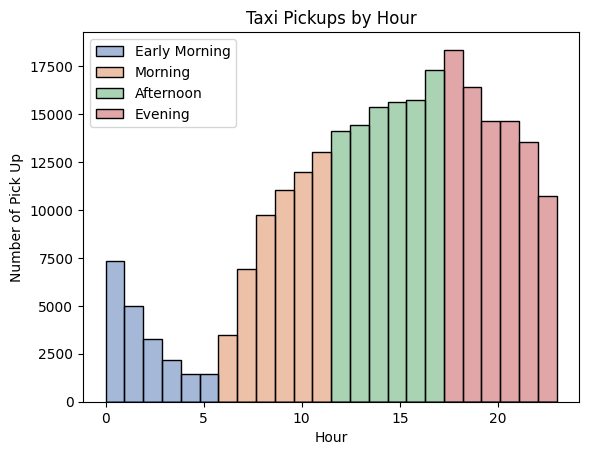

In [404]:
# Find and show the hourly trends in taxi pickups
eda_df = cleaned_df.copy()
eda_df['pickup_hour'] = eda_df['tpep_pickup_datetime'].dt.hour

# To better categorize the hours within a day, we divide the hours into 4 bins
bins = [0, 6, 12, 18, 24]
labels = ['Early Morning', 'Morning', 'Afternoon', 'Evening']
eda_df['pickup_bin'] = pd.cut(eda_df['pickup_hour'], bins=bins, labels=labels, right=False)

# Visualize the hourly trends
ax = sns.histplot(data=eda_df, x='pickup_hour', hue='pickup_bin', bins=24)
plt.title('Taxi Pickups by Hour')
plt.ylabel('Number of Pick Up')
plt.xlabel('Hour')
ax.get_legend().set_title('')
plt.show()


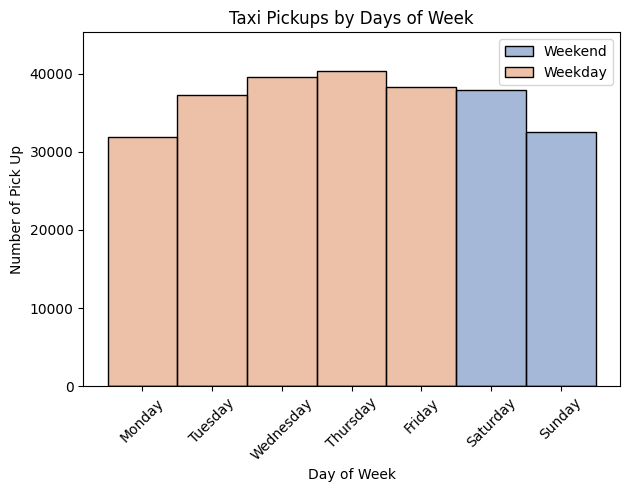

In [405]:
# Find and show the daily trends in taxi pickups (days of the week)

days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

eda_df['pickup_weekday'] = eda_df['tpep_pickup_datetime'].dt.day_name()
eda_df['pickup_weekday'] = pd.Categorical(eda_df['pickup_weekday'], categories=days_order, ordered=True)
eda_df.loc[eda_df['pickup_weekday'].isin(['Saturday', 'Sunday']), 'pickup_weekend'] = 'Weekend'
eda_df['pickup_weekend'] = eda_df['pickup_weekend'].fillna('Weekday')

# Visualize the days of week pickup trends
ax = sns.histplot(data=eda_df, x='pickup_weekday', bins=7, hue='pickup_weekend')
ax.legend_.set_title(None)
y_max = ax.get_ylim()[1]
ax.set_ylim(0, y_max * 1.07)
plt.xticks(rotation=45)
plt.tight_layout()
plt.title('Taxi Pickups by Days of Week')
plt.ylabel('Number of Pick Up')
plt.xlabel('Day of Week')
plt.show()


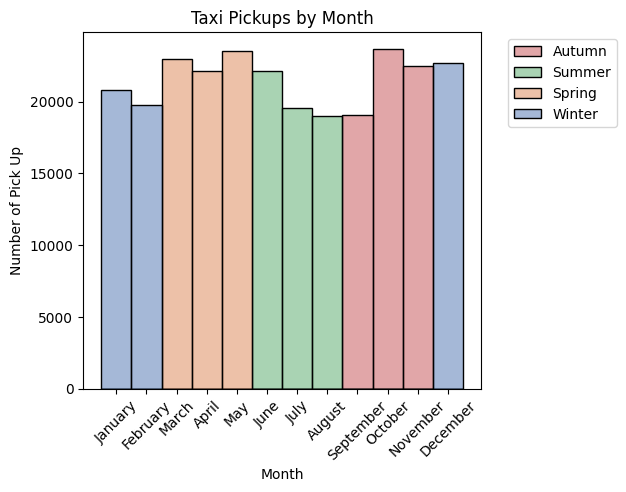

In [406]:
# Show the monthly trends in pickups

eda_df['pickup_month'] = eda_df['tpep_pickup_datetime'].dt.month_name()
season_map = {
    'December': 'Winter', 'January': 'Winter', 'February': 'Winter',
    'March': 'Spring', 'April': 'Spring', 'May': 'Spring',
    'June': 'Summer', 'July': 'Summer', 'August': 'Summer',
    'September': 'Fall', 'October': 'Fall', 'November': 'Fall'
}

eda_df['pickup_season'] = eda_df['pickup_month'].map(season_map)

# Visualize the monthly pickup trends
ax = sns.histplot(data=eda_df, x='pickup_month', bins=12, hue='pickup_season')

plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), title=None, labels=['Autumn', 'Summer', 'Spring', 'Winter'])  # Move legend outside

plt.subplots_adjust(right=0.85)
plt.xticks(rotation=45)
plt.tight_layout()
plt.title('Taxi Pickups by Month')
plt.ylabel('Number of Pick Up')
plt.xlabel('Month')
plt.show()

##### Financial Analysis

Take a look at the financial parameters like `fare_amount`, `tip_amount`, `total_amount`, and also `trip_distance`. Do these contain zero/negative values?

In [ ]:
# Analyse the above parameters
(eda_df[['fare_amount', 'tip_amount', 'trip_distance']] <= 0).sum()

# All the negative values have been dealt with by replacing them with the absolute values
# Zero values for fare_amount have been considered outliers and were discarded. 
# tip_amount is almost always 0 for cash payment. We can discard those values when we do tip analysis.


fare_amount          0
tip_amount       59540
trip_distance     3866
dtype: int64

Do you think it is beneficial to create a copy DataFrame leaving out the zero values from these?

**3.1.3** <font color = red>[2 marks]</font> <br>
Filter out the zero values from the above columns.

**Note:** The distance might be 0 in cases where pickup and drop is in the same zone. Do you think it is suitable to drop such cases of zero distance?

In [ ]:
# Create a df with non zero entries for the selected parameters.

eda_df_non_zeroes = eda_df[(eda_df[['fare_amount', 'tip_amount', 'trip_distance']] != 0).all(axis=1)]
eda_df_non_zeroes
# trip_distance equal to 0 are not impossible and can be kept as is. We can discard them for trip_distance related analysis

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,...,congestion_surcharge,airport_fee,trip_duration_minutes,Vendor,pickup_hour,pickup_bin,pickup_weekday,pickup_weekend,pickup_month,pickup_season
0,1,2023-01-01 00:23:23,2023-01-01 00:45:35,1.000000,5.400000,1.000000,239,107,1,25.400000,...,2.500000,0.000000,22.200000,"Creative Mobile Technologies, LLC",0,Early Morning,Sunday,Weekend,January,Winter
3,2,2023-01-01 00:54:00,2023-01-01 01:27:00,1.000000,0.240000,1.000000,143,148,0,36.440000,...,2.500000,0.000000,33.000000,"Curb Mobility, LLC",0,Early Morning,Sunday,Weekend,January,Winter
4,1,2023-01-01 00:12:09,2023-01-01 00:36:30,1.000000,4.400000,1.000000,239,90,1,25.400000,...,2.500000,0.000000,24.350000,"Creative Mobile Technologies, LLC",0,Early Morning,Sunday,Weekend,January,Winter
5,2,2023-01-01 00:51:10,2023-01-01 01:21:38,1.000000,13.150000,1.000000,225,74,0,50.810000,...,2.500000,0.000000,30.466667,"Curb Mobility, LLC",0,Early Morning,Sunday,Weekend,January,Winter
6,2,2023-01-01 00:08:32,2023-01-01 00:16:33,1.000000,1.850000,1.000000,239,50,1,10.700000,...,2.500000,0.000000,8.016667,"Curb Mobility, LLC",0,Early Morning,Sunday,Weekend,January,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268142,1,2023-12-31 09:49:27,2023-12-31 10:08:45,1.000000,18.800000,2.000000,75,132,1,70.000000,...,0.000000,0.000000,19.300000,"Creative Mobile Technologies, LLC",9,Morning,Sunday,Weekend,December,Winter
268143,2,2023-12-31 09:48:27,2023-12-31 09:58:39,1.000000,2.520000,1.000000,141,238,1,13.500000,...,2.500000,0.000000,10.200000,"Curb Mobility, LLC",9,Morning,Sunday,Weekend,December,Winter
268146,1,2023-12-31 09:59:03,2023-12-31 10:10:58,4.000000,3.100000,1.000000,170,239,1,15.600000,...,2.500000,0.000000,11.916667,"Creative Mobile Technologies, LLC",9,Morning,Sunday,Weekend,December,Winter
268147,1,2023-12-31 09:48:55,2023-12-31 09:56:42,1.000000,1.600000,1.000000,163,236,1,10.000000,...,2.500000,0.000000,7.783333,"Creative Mobile Technologies, LLC",9,Morning,Sunday,Weekend,December,Winter


**3.1.4** <font color = red>[3 marks]</font> <br>
Analyse the monthly revenue (`total_amount`) trend

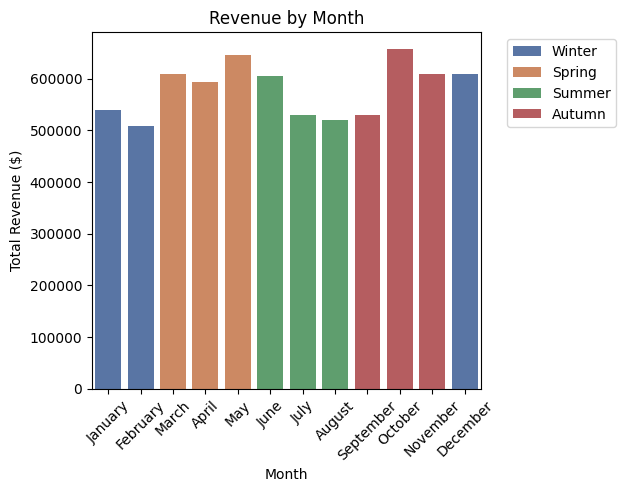

In [407]:
# Group data by month and analyse monthly revenue


# Visualize the monthly revenue
ax = sns.barplot(data=eda_df, x='pickup_month', y='total_amount' , hue='pickup_season', errorbar=None, estimator=np.sum)

plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), title=None, labels=['Winter', 'Spring', 'Summer', 'Autumn'])  # Move legend outside

plt.subplots_adjust(right=0.85)
plt.xticks(rotation=45)
plt.tight_layout()
plt.title('Revenue by Month')
plt.ylabel('Total Revenue ($)')
plt.xlabel('Month')
plt.show()

**3.1.5** <font color = red>[3 marks]</font> <br>
Show the proportion of each quarter of the year in the revenue

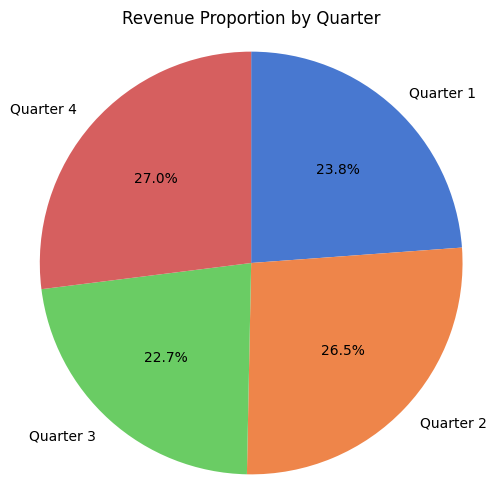

In [221]:
# Calculate proportion of each quarter
eda_df['pickup_quarter'] = eda_df['tpep_pickup_datetime'].dt.quarter
eda_df['quarter_label'] = 'Quarter ' + eda_df['pickup_quarter'].astype(str)
quarter_revenue = eda_df.groupby(['quarter_label'])['total_amount'].sum().reset_index()


colors = sns.color_palette("muted")

plt.figure(figsize=(6, 6))
plt.pie(quarter_revenue['total_amount'], labels=quarter_revenue['quarter_label'], autopct='%1.1f%%', startangle=90, counterclock=False, colors=colors)
plt.title('Revenue Proportion by Quarter')
plt.axis('equal')  # Equal aspect ratio ensures the pie is a circle.
plt.show()

**3.1.6** <font color = red>[3 marks]</font> <br>
Visualise the relationship between `trip_distance` and `fare_amount`. Also find the correlation value for these two.

**Hint:** You can leave out the trips with trip_distance = 0

               trip_distance  fare_amount
trip_distance       1.000000     0.952718
fare_amount         0.952718     1.000000


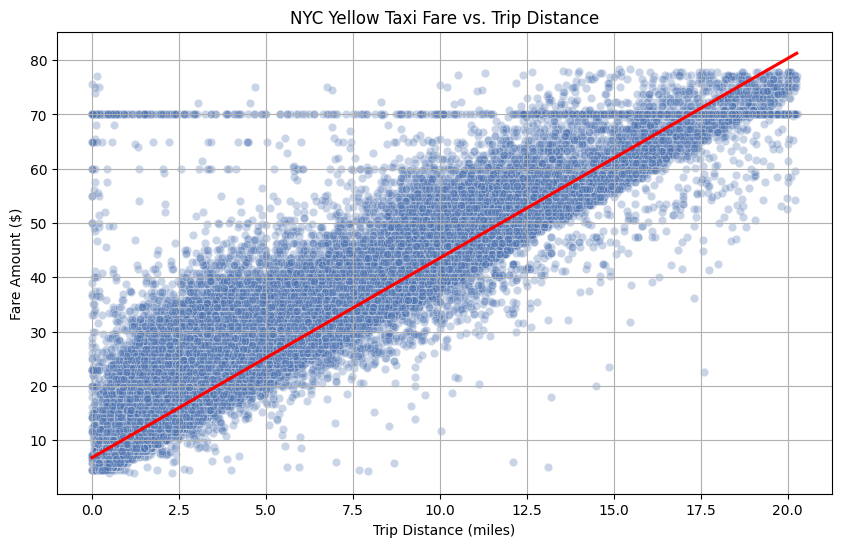

In [222]:
# Show how trip fare is affected by distance

trip_fare_eda_df = eda_df[(eda_df['trip_distance'] > 0) & (eda_df['fare_amount'] > 0)]

print(trip_fare_eda_df[['trip_distance', 'fare_amount']].corr())

plt.figure(figsize=(10, 6))
sns.scatterplot(x='trip_distance', y='fare_amount', data=trip_fare_eda_df, alpha=0.3)
sns.regplot(x='trip_distance', y='fare_amount', data=trip_fare_eda_df, scatter=False, color='red')
plt.title('NYC Yellow Taxi Fare vs. Trip Distance')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Fare Amount ($)')
plt.grid(True)
plt.show()

In [223]:
trip_fare_eda_df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'PULocationID',
       'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'tip_amount',
       'total_amount', 'congestion_surcharge', 'airport_fee',
       'trip_duration_minutes', 'Vendor', 'pickup_hour', 'pickup_bin',
       'pickup_weekday', 'pickup_weekend', 'pickup_month', 'pickup_season',
       'pickup_quarter', 'quarter_label'],
      dtype='object')

**3.1.7** <font color = red>[5 marks]</font> <br>
Find and visualise the correlation between:
1. `fare_amount` and trip duration (pickup time to dropoff time)
2. `fare_amount` and `passenger_count`
3. `tip_amount` and `trip_distance`

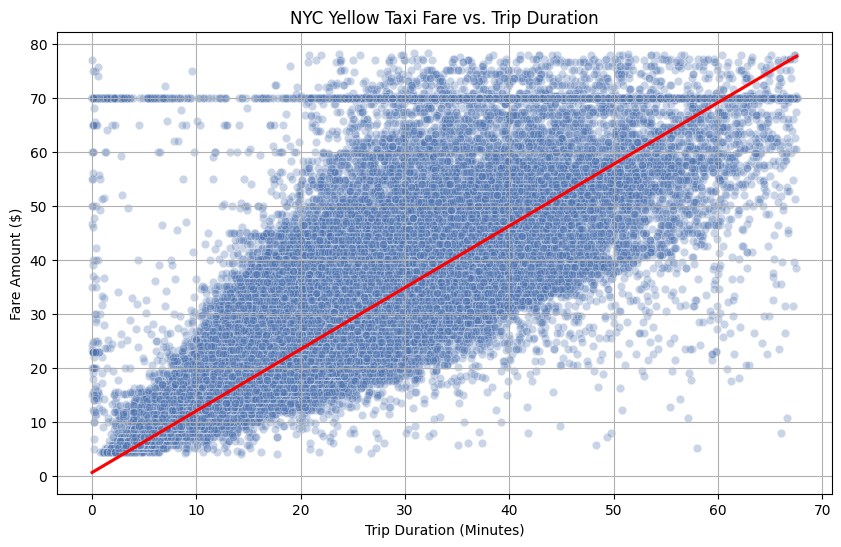

In [224]:
# Show relationship between fare and trip duration

plt.figure(figsize=(10, 6))
sns.scatterplot(x='trip_duration_minutes', y='fare_amount', data=trip_fare_eda_df, alpha=0.3)
sns.regplot(x='trip_duration_minutes', y='fare_amount', data=trip_fare_eda_df, scatter=False, color='red')
plt.title('NYC Yellow Taxi Fare vs. Trip Duration')
plt.xlabel('Trip Duration (Minutes)')
plt.ylabel('Fare Amount ($)')
plt.grid(True)
plt.show()

                 passenger_count  fare_amount
passenger_count         1.000000     0.033700
fare_amount             0.033700     1.000000


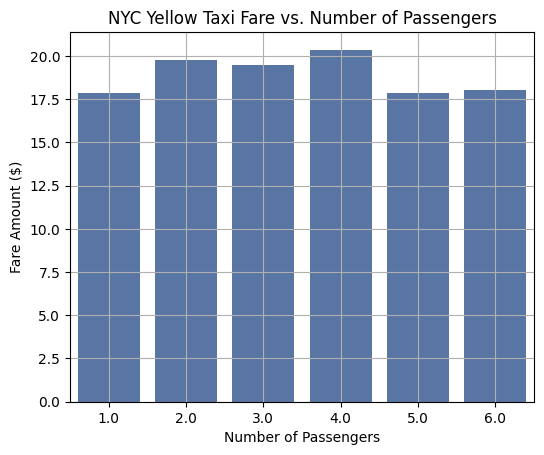

In [ ]:
# Show relationship between fare and number of passengers

print(trip_fare_eda_df[['passenger_count', 'fare_amount']].corr())

ax = sns.barplot(data=trip_fare_eda_df, x='passenger_count', y='fare_amount', errorbar=None, estimator=np.mean)
plt.subplots_adjust(right=0.85)
plt.title('NYC Yellow Taxi Fare vs. Number of Passengers')
plt.xlabel('Number of Passengers')
plt.ylabel('Fare Amount ($)')
plt.grid(True)
plt.show()

               trip_distance  tip_amount
trip_distance       1.000000    0.573059
tip_amount          0.573059    1.000000


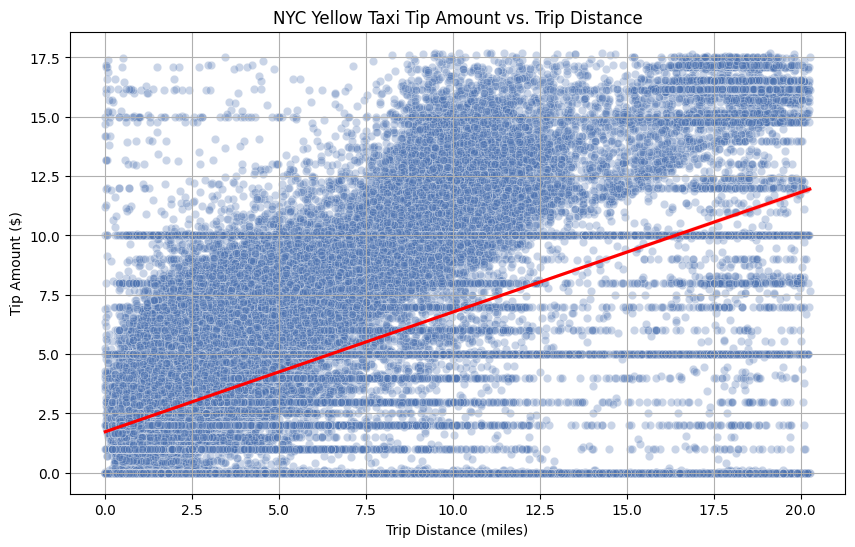

In [411]:
# Show relationship between tip and trip distance

print(trip_fare_eda_df[['trip_distance', 'tip_amount']].corr())

plt.figure(figsize=(10, 6))
sns.scatterplot(x='trip_distance', y='tip_amount', data=trip_fare_eda_df, alpha=0.3)
sns.regplot(x='trip_distance', y='tip_amount', data=trip_fare_eda_df, scatter=False, color='red')
plt.title('NYC Yellow Taxi Tip Amount vs. Trip Distance')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Tip Amount ($)')
plt.grid(True)
plt.show()

**3.1.8** <font color = red>[3 marks]</font> <br>
Analyse the distribution of different payment types (`payment_type`)

payment_label
Credit Card      78.400000
Cash             16.500000
Flex Fare trip    3.500000
Dispute           1.100000
No Charge         0.500000
Name: proportion, dtype: float64


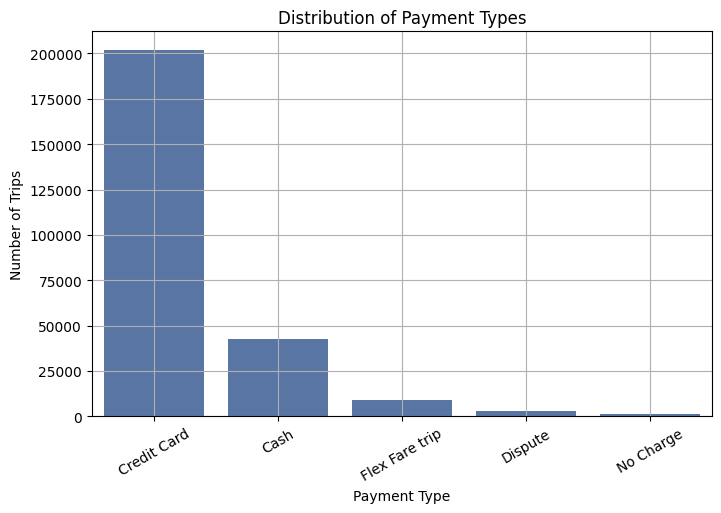

In [227]:
# Analyse the distribution of different payment types (payment_type).
payment_mapping = {
    0: 'Flex Fare trip',
    1: 'Credit Card',
    2: 'Cash',
    3: 'No Charge',
    4: 'Dispute',
    5: 'Unknown',
    6: 'Voided Trip'
}
eda_df['payment_label'] = eda_df['payment_type'].map(payment_mapping)
print(eda_df['payment_label'].value_counts(normalize=True).round(3) * 100)

# Count plot
plt.figure(figsize=(8, 5))
sns.countplot(x='payment_label', data=eda_df, order=eda_df['payment_label'].value_counts().index)
plt.title('Distribution of Payment Types')
plt.xlabel('Payment Type')
plt.ylabel('Number of Trips')
plt.xticks(rotation=30)
plt.grid(True)
plt.show()

- 1= Credit card
- 2= Cash
- 3= No charge
- 4= Dispute



##### Geographical Analysis

For this, you have to use the *taxi_zones.shp* file from the *taxi_zones* folder.

There would be multiple files inside the folder (such as *.shx, .sbx, .sbn* etc). You do not need to import/read any of the files other than the shapefile, *taxi_zones.shp*.

Do not change any folder structure - all the files need to be present inside the folder for it to work.

The folder structure should look like this:
```
Taxi Zones
|- taxi_zones.shp.xml
|- taxi_zones.prj
|- taxi_zones.sbn
|- taxi_zones.shp
|- taxi_zones.dbf
|- taxi_zones.shx
|- taxi_zones.sbx

 ```

 You only need to read the `taxi_zones.shp` file. The *shp* file will utilise the other files by itself.

We will use the *GeoPandas* library for geopgraphical analysis
```
import geopandas as gpd
```

More about geopandas and shapefiles: [About](https://geopandas.org/en/stable/about.html)


Reading the shapefile is very similar to *Pandas*. Use `gpd.read_file()` function to load the data (*taxi_zones.shp*) as a GeoDataFrame. Documentation: [Reading and Writing Files](https://geopandas.org/en/stable/docs/user_guide/io.html)

In [228]:
# !pip install geopandas

**3.1.9** <font color = red>[2 marks]</font> <br>
Load the shapefile and display it.

In [229]:
import geopandas as gpd


# Read the shapefile using geopandas
# zones = gpd.read_file('C:\\Users\\Admin\\OneDrive\\Mic\\Study\\Master\\NYC Taxi\\Data\\taxi_zones\\taxi_zones.shp') # read the .shp file using gpd - MSI
zones = gpd.read_file('C:\\Users\\nguye\\OneDrive\\Mic\\Study\\Master\\NYC Taxi\\Data\\taxi_zones\\taxi_zones.shp') # read the .shp file using gpd - PC
# zones = gpd.read_file('C:\\Users\\dle2\\OneDrive - Capgemini\\Mike\\Study\\Master\\NYC Yellow Taxi\\Data\\taxi_zones\\taxi_zones.shp') # read the .shp file using gpd - Dell

zones.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.77 256767.698, 1026495.593 2..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.31 144283.336, 936046.565 144..."


Now, if you look at the DataFrame created, you will see columns like: `OBJECTID`,`Shape_Leng`, `Shape_Area`, `zone`, `LocationID`, `borough`, `geometry`.
<br><br>

Now, the `locationID` here is also what we are using to mark pickup and drop zones in the trip records.

The geometric parameters like shape length, shape area and geometry are used to plot the zones on a map.

This can be easily done using the `plot()` method.

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    263 non-null    int32   
 1   Shape_Leng  263 non-null    float64 
 2   Shape_Area  263 non-null    float64 
 3   zone        263 non-null    object  
 4   LocationID  263 non-null    int32   
 5   borough     263 non-null    object  
 6   geometry    263 non-null    geometry
dtypes: float64(2), geometry(1), int32(2), object(2)
memory usage: 12.5+ KB
None


<Axes: >

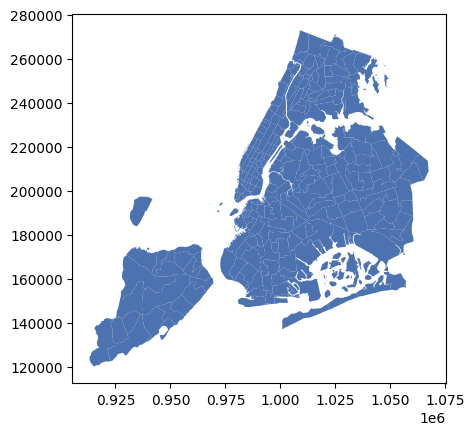

In [230]:
print(zones.info())
zones.plot()

Now, you have to merge the trip records and zones data using the location IDs.



**3.1.10** <font color = red>[3 marks]</font> <br>
Merge the zones data into trip data using the `locationID` and `PULocationID` columns.

In [231]:
# Merge zones and trip records using locationID and PULocationID

zoned_df = eda_df.merge(zones, left_on='PULocationID', right_on='LocationID', how='left')
print(zoned_df[zoned_df['LocationID'].isna()]['PULocationID'].unique()) # We don't have zone information for LocationID 264 and 265, thus those will be left out in the analysis
zoned_df.head()

[264 265]


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,...,pickup_quarter,quarter_label,payment_label,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,2023-01-01 00:23:23,2023-01-01 00:45:35,1.000000,5.400000,1.000000,239,107,1,25.400000,...,1,Quarter 1,Credit Card,239.000000,0.063626,0.000205,Upper West Side South,239.000000,Manhattan,"POLYGON ((991168.979 226252.992, 991955.565 22..."
1,2,2023-01-01 00:21:57,2023-01-01 00:32:21,1.000000,1.470000,1.000000,141,141,2,11.400000,...,1,Quarter 1,Cash,141.000000,0.041514,0.000077,Lenox Hill West,141.000000,Manhattan,"POLYGON ((994839.073 216123.698, 994786.74 216..."
2,2,2023-01-01 00:54:00,2023-01-01 01:27:00,1.000000,0.240000,1.000000,143,148,0,36.440000,...,1,Quarter 1,Flex Fare trip,143.000000,0.054180,0.000151,Lincoln Square West,143.000000,Manhattan,"POLYGON ((989338.1 223572.253, 989368.225 2235..."
3,1,2023-01-01 00:12:09,2023-01-01 00:36:30,1.000000,4.400000,1.000000,239,90,1,25.400000,...,1,Quarter 1,Credit Card,239.000000,0.063626,0.000205,Upper West Side South,239.000000,Manhattan,"POLYGON ((991168.979 226252.992, 991955.565 22..."
4,2,2023-01-01 00:51:10,2023-01-01 01:21:38,1.000000,13.150000,1.000000,225,74,0,50.810000,...,1,Quarter 1,Flex Fare trip,225.000000,0.088799,0.000311,Stuyvesant Heights,225.000000,Brooklyn,"POLYGON ((1007155.288 188499.273, 1007196.203 ..."


**3.1.11** <font color = red>[3 marks]</font> <br>
Group data by location IDs to find the total number of trips per location ID

In [232]:
# Group data by location and calculate the number of trips

location_count = zoned_df.groupby('LocationID')['LocationID'].count().rename('trip_count').reset_index()
location_count

,LocationID,trip_count
0,1.000000,3
1,2.000000,1
2,3.000000,5
3,4.000000,327
4,5.000000,1
...,...,...
227,259.000000,7
228,260.000000,43
229,261.000000,1296
230,262.000000,3462


**3.1.12** <font color = red>[2 marks]</font> <br>
Now, use the grouped data to add number of trips to the GeoDataFrame.

We will use this to plot a map of zones showing total trips per zone.

In [233]:
# Merge trip counts back to the zones GeoDataFrame

zone_count = zones.merge(location_count, how='left', on='LocationID')
print(zone_count[zone_count['trip_count'].isna()]['LocationID'].unique())
zone_count

[  6   8   9  27  30  84  96  99 101 103 109 110 111 115 120 153 156 172
 176 187 199 204 206 214 221 240 245 253]


,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,trip_count
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19...",3.000000
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343...",1.000000
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.77 256767.698, 1026495.593 2...",5.000000
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20...",327.000000
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.31 144283.336, 936046.565 144...",1.000000
...,...,...,...,...,...,...,...,...
258,259,0.126750,0.000395,Woodlawn/Wakefield,259,Bronx,"POLYGON ((1025414.782 270986.139, 1025138.624 ...",7.000000
259,260,0.133514,0.000422,Woodside,260,Queens,"POLYGON ((1011466.966 216463.005, 1011545.889 ...",43.000000
260,261,0.027120,0.000034,World Trade Center,261,Manhattan,"POLYGON ((980555.204 196138.486, 980570.792 19...",1296.000000
261,262,0.049064,0.000122,Yorkville East,262,Manhattan,"MULTIPOLYGON (((999804.795 224498.527, 999824....",3462.000000


The next step is creating a color map (choropleth map) showing zones by the number of trips taken.

Again, you can use the `zones.plot()` method for this. [Plot Method GPD](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html#geopandas.GeoDataFrame.plot)

But first, you need to define the figure and axis for the plot.

`fig, ax = plt.subplots(1, 1, figsize = (12, 10))`

This function creates a figure (fig) and a single subplot (ax)

---

After setting up the figure and axis, we can proceed to plot the GeoDataFrame on this axis. This is done in the next step where we use the plot method of the GeoDataFrame.

You can define the following parameters in the `zones.plot()` method:
```
column = '',
ax = ax,
legend = True,
legend_kwds = {'label': "label", 'orientation': "<horizontal/vertical>"}
```

To display the plot, use `plt.show()`.

**3.1.13** <font color = red>[3 marks]</font> <br>
Plot a color-coded map showing zone-wise trips

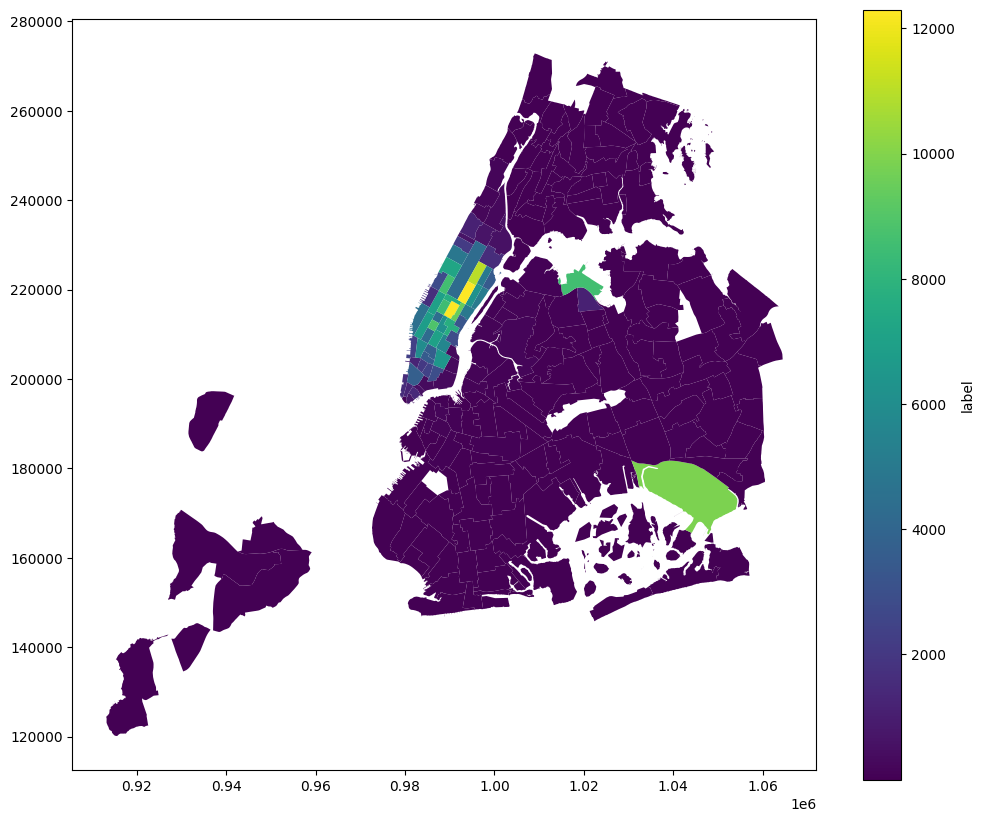

In [234]:
# Define figure and axis
fig, ax = plt.subplots(1, 1, figsize = (12, 10))


# Plot the map and display it
zone_count.plot(
    column = 'trip_count',
    ax = ax,
    legend = True,
    legend_kwds = {'label': "label", 'orientation': "vertical"}
)
plt.show()


In [235]:
# can you try displaying the zones DF sorted by the number of trips?
zone_count['trip_count'] = zone_count['trip_count'].fillna(0)
zone_count['trip_count'] = zone_count['trip_count'].astype('Int64')
zone_count.sort_values('trip_count', ascending=False)

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,trip_count
160,161,0.035804,0.000072,Midtown Center,161,Manhattan,"POLYGON ((991081.026 214453.698, 990952.644 21...",12298
236,237,0.042213,0.000096,Upper East Side South,237,Manhattan,"POLYGON ((993633.442 216961.016, 993507.232 21...",12261
235,236,0.044252,0.000103,Upper East Side North,236,Manhattan,"POLYGON ((995940.048 221122.92, 995812.322 220...",11031
131,132,0.245479,0.002038,JFK Airport,132,Queens,"MULTIPOLYGON (((1032791.001 181085.006, 103283...",9850
161,162,0.035270,0.000048,Midtown East,162,Manhattan,"POLYGON ((992224.354 214415.293, 992096.999 21...",9457
...,...,...,...,...,...,...,...,...
213,214,0.135300,0.000812,South Beach/Dongan Hills,214,Staten Island,"POLYGON ((960669.201 156319.132, 960902.551 15...",0
220,221,0.166218,0.000890,Stapleton,221,Staten Island,"POLYGON ((963349.728 171627.581, 963397.759 17...",0
26,27,0.202509,0.001341,Breezy Point/Fort Tilden/Riis Beach,27,Queens,"POLYGON ((1021692.969 147138.664, 1021883.624 ...",0
29,30,0.094510,0.000146,Broad Channel,30,Queens,"POLYGON ((1034013.272 163473.152, 1034866.459 ...",0


Here we have completed the temporal, financial and geographical analysis on the trip records.

**Compile your findings from general analysis below:**

You can consider the following points:

* Busiest hours, days and months
* Trends in revenue collected
* Trends in quarterly revenue
* How fare depends on trip distance, trip duration and passenger counts
* How tip amount depends on trip distance
* Busiest zones


Busiest Times: Peak hours are 5–7 PM; busiest days are Wednesday and Thursday.

Seasonal Trends: Demand and revenue peak in spring and September, dip during summer.

Revenue: Q2 and Q4 contribute the most to yearly earnings.

Fare Drivers: Fare increases with distance and duration; more passengers reduce fare per person.

Tips: Higher on longer trips.

Hot Zones: Midtown and Financial District have the most trips; airports also see high activity.

Insight: Taxi services are centralized in Manhattan, with growth potential in outer boroughs.

#### **3.2** Detailed EDA: Insights and Strategies
<font color = red>[50 marks]</font> <br>

Having performed basic analyses for finding trends and patterns, we will now move on to some detailed analysis focussed on operational efficiency, pricing strategies, and customer experience.

##### Operational Efficiency

Analyze variations by time of day and location to identify bottlenecks or inefficiencies in routes

**3.2.1** <font color = red>[3 marks]</font> <br>
Identify slow routes by calculating the average time taken by cabs to get from one zone to another at different hours of the day.

Speed on a route *X* for hour *Y* = (*distance of the route X / average trip duration for hour Y*)

In [442]:
# Find routes which have the slowest speeds at different times of the day
location_dict = zones[['LocationID', 'zone']].set_index('LocationID')['zone'].to_dict()
route_df = eda_df.copy()
route_df['pickup_zone'] = route_df['PULocationID'].map(location_dict)
route_df['dropoff_zone'] = route_df['DOLocationID'].map(location_dict)
route_df['route'] = route_df['pickup_zone'] + ' - ' + route_df['dropoff_zone']
route_df['miles_per_hour'] = route_df['trip_distance'] / route_df['trip_duration_minutes'] * 60

average_speed = route_df.groupby(['pickup_hour']).agg({'miles_per_hour':'mean', 'pickup_zone':'count'})
average_speed = average_speed.rename(columns={'miles_per_hour':'average_speed', 'pickup_zone':'trip_count'})
average_speed = average_speed[average_speed['trip_count'] >= 8] # Only account for routes with at least 8 trips to avoid low sample outliers
average_speed = average_speed.drop(columns=['trip_count'])

slowest_routes = route_df.groupby(['route', 'pickup_hour']).agg({'miles_per_hour':'mean', 'pickup_zone':'count'})
slowest_routes = slowest_routes.rename(columns={'pickup_zone':'trip_count'})
slowest_routes = slowest_routes[slowest_routes['trip_count'] >= 8] # Only account for routes with at least 8 trips to avoid low sample outliers
slowest_routes = slowest_routes.sort_values('miles_per_hour', ascending=True).reset_index()
slowest_routes = slowest_routes.drop_duplicates(subset='pickup_hour', keep='first')
slowest_routes = slowest_routes.sort_values('pickup_hour', ascending=True).reset_index(drop=True)
slowest_routes = slowest_routes.merge(average_speed, on='pickup_hour', how='left')
slowest_routes['speed_difference'] = slowest_routes['average_speed'] - slowest_routes['miles_per_hour']
slowest_routes['slower_from_average'] = slowest_routes['speed_difference'] / slowest_routes['average_speed']
slowest_routes

,route,pickup_hour,miles_per_hour,trip_count,average_speed,speed_difference,slower_from_average
0,Lower East Side - Lower East Side,0,5.495298,11,14.128728,8.633429,0.611055
1,Greenwich Village South - Lower East Side,1,6.979724,13,14.003382,7.023659,0.501569
2,Lower East Side - Lower East Side,2,5.709006,8,14.448585,8.739579,0.604874
3,Lower East Side - Lower East Side,3,7.392682,10,16.259046,8.866363,0.545319
4,East Village - East Village,4,7.452322,8,17.560982,10.108660,0.575632
5,Garment District - Midtown Center,5,10.611321,22,19.111822,8.500501,0.444777
6,Clinton East - Times Sq/Theatre District,6,7.989393,14,16.095760,8.106367,0.503634
7,Garment District - Midtown Center,7,6.690575,29,12.982792,6.292217,0.484658
8,West Chelsea/Hudson Yards - Midtown South,8,5.339175,8,10.989847,5.650672,0.514172
9,Penn Station/Madison Sq West - Clinton East,9,4.367105,10,10.650390,6.283285,0.589958


How does identifying high-traffic, high-demand routes help us?

**3.2.2** <font color = red>[3 marks]</font> <br>
Calculate the number of trips at each hour of the day and visualise them. Find the busiest hour and show the number of trips for that hour.

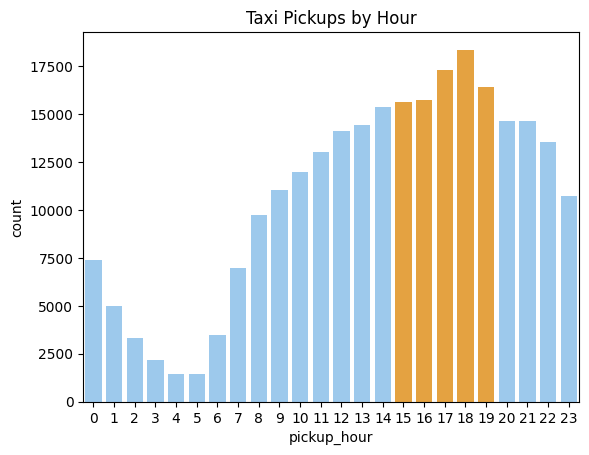

In [238]:
# Visualise the number of trips per hour and find the busiest hour
hours_count = route_df['pickup_hour'].value_counts().reset_index()
busiest_hours = hours_count.iloc[:5]['pickup_hour']
busiest_hours_count = hours_count.iloc[:5]['count']

colors = ['#FFA726' if v in busiest_hours.values else '#90CAF9' for v in sorted(hours_count['pickup_hour'].values)] 
sns.barplot(data=hours_count, x='pickup_hour', y='count', palette=colors, hue='pickup_hour', legend=False)
plt.title('Taxi Pickups by Hour')
plt.show()


Remember, we took a fraction of trips. To find the actual number, you have to scale the number up by the sampling ratio.

**3.2.3** <font color = red>[2 mark]</font> <br>
Find the actual number of trips in the five busiest hours

In [239]:
# Scale up the number of trips

# Fill in the value of your sampling fraction and use that to scale up the numbers
sample_fraction = 0.007
for i in range(len(busiest_hours)):
    print(f'Estimation of the number of taxi trips at the top {i + 1} busiest hour ({busiest_hours[i]}) is {round(busiest_hours_count[i] / 0.007)}')


Estimation of the number of taxi trips at the top 1 busiest hour (18) is 2622571
Estimation of the number of taxi trips at the top 2 busiest hour (17) is 2469286
Estimation of the number of taxi trips at the top 3 busiest hour (19) is 2346857
Estimation of the number of taxi trips at the top 4 busiest hour (16) is 2245000
Estimation of the number of taxi trips at the top 5 busiest hour (15) is 2234286


**3.2.4** <font color = red>[3 marks]</font> <br>
Compare hourly traffic pattern on weekdays. Also compare for weekend.

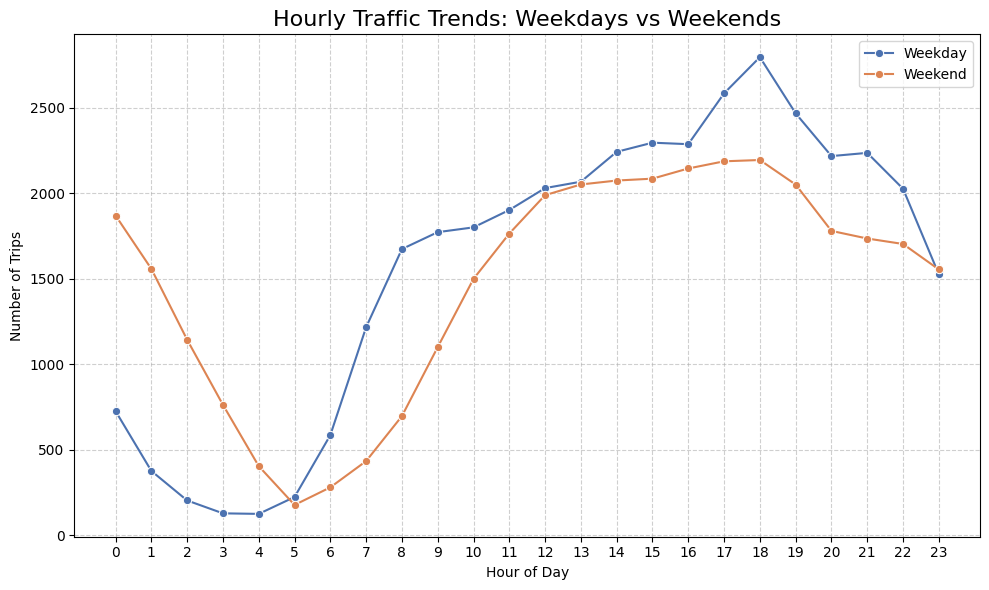

In [443]:
# Compare traffic trends for the week days and weekends

weekday_trends = route_df.copy()
weekday_trends = weekday_trends.groupby(['pickup_weekday', 'pickup_weekend', 'pickup_hour'], observed=True)['pickup_weekend'].count().rename('trip_count').reset_index()

plt.figure(figsize=(10, 6))
ax = sns.lineplot(data=weekday_trends, x='pickup_hour', y='trip_count', hue='pickup_weekend', marker='o', errorbar=None)

plt.title("Hourly Traffic Trends: Weekdays vs Weekends", fontsize=16)
plt.xlabel("Hour of Day")
plt.ylabel("Number of Trips")
plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
ax.get_legend().set_title('')
plt.show()

What can you infer from the above patterns? How will finding busy and quiet hours for each day help us?

**3.2.5** <font color = red>[3 marks]</font> <br>
Identify top 10 zones with high hourly pickups. Do the same for hourly dropoffs. Show pickup and dropoff trends in these zones.

In [ ]:
# Find top 10 pickup and dropoff zones

# Assume that we are taking the top 10 zones with the most pick up trips, and not the top 10 combination of zones and pick up hours (which means one zone can appear multiple times)
pickups = route_df['pickup_zone'].value_counts(dropna=False).rename('pickup_count').reset_index()
pickups['pickup_count'] = pickups['pickup_count'].fillna(0)
pickups = pickups.rename(columns={'pickup_zone':'zone'})
top_10_pickups = pickups.iloc[:10].copy()
top_10_pickups['pickup_rank'] = top_10_pickups.index + 1
display(top_10_pickups)

# The same assumption goes for top 10 drop off zones
dropoffs = route_df['dropoff_zone'].value_counts(dropna=False).rename('dropoff_count').reset_index()
dropoffs['dropoff_count'] = dropoffs['dropoff_count'].fillna(0)
dropoffs = dropoffs.rename(columns={'dropoff_zone':'zone'})

top_10_dropoffs = dropoffs.iloc[:10].copy()
top_10_dropoffs['dropoff_rank'] = top_10_dropoffs.index + 1
display(top_10_dropoffs)

,zone,pickup_count,pickup_rank
0,Midtown Center,12298,1
1,Upper East Side South,12261,2
2,Upper East Side North,11031,3
3,JFK Airport,9850,4
4,Midtown East,9457,5
5,Penn Station/Madison Sq West,8847,6
6,LaGuardia Airport,8574,7
7,Lincoln Square East,8560,8
8,Times Sq/Theatre District,8474,9
9,Murray Hill,7688,10


,zone,dropoff_count,dropoff_rank
0,Upper East Side North,11477,1
1,Upper East Side South,10915,2
2,Midtown Center,10114,3
3,Times Sq/Theatre District,7845,4
4,Murray Hill,7684,5
5,Midtown East,7511,6
6,Lincoln Square East,7426,7
7,Upper West Side South,7109,8
8,Lenox Hill West,6899,9
9,East Chelsea,6594,10


**3.2.6** <font color = red>[3 marks]</font> <br>
Find the ratio of pickups and dropoffs in each zone. Display the 10 highest (pickup/drop) and 10 lowest (pickup/drop) ratios.

In [243]:
# Find the top 10 and bottom 10 pickup/dropoff ratios
# Use inner join as we only want zones with both pickup and dropoff trips
pick_drop_ratio = pd.merge(pickups, dropoffs, on='zone', how='inner') 
# Keep only zones with at least more than 100 pick up or drop off trips to improve the reliability of the analysis
pick_drop_ratio = pick_drop_ratio.loc[(pick_drop_ratio['pickup_count'] >= 100) | (pick_drop_ratio['dropoff_count'] >= 100)]
pick_drop_ratio['pick/drop_ratio'] = pick_drop_ratio['pickup_count'] / pick_drop_ratio['dropoff_count']
pick_drop_ratio = pick_drop_ratio.sort_values('pick/drop_ratio', ascending=False).reset_index(drop=True)
pick_drop_ratio
print('Top 10 zones with the highest pickup/drop ratio')
display(pick_drop_ratio.iloc[:10])
print('Top 10 zones with the lowest pickup/drop ratio')
display(pick_drop_ratio.iloc[-10:])

Top 10 zones with the highest pickup/drop ratio


,zone,pickup_count,dropoff_count,pick/drop_ratio
0,East Elmhurst,1109,107,10.364486
1,JFK Airport,9850,2033,4.845057
2,LaGuardia Airport,8574,3289,2.606871
3,Penn Station/Madison Sq West,8847,5798,1.525871
4,Greenwich Village South,3531,2534,1.393449
5,Central Park,4289,3250,1.319692
6,West Village,5945,4535,1.310915
7,Midtown East,9457,7511,1.259087
8,Garment District,4370,3563,1.226495
9,Midtown Center,12298,10114,1.215938


Top 10 zones with the lowest pickup/drop ratio


,zone,pickup_count,dropoff_count,pick/drop_ratio
102,South Ozone Park,28,233,0.120172
103,South Williamsburg,10,104,0.096154
104,Greenpoint,56,591,0.094755
105,Inwood,13,145,0.089655
106,Bushwick South,25,280,0.089286
107,Bedford,25,293,0.085324
108,Washington Heights North,38,451,0.084257
109,Flushing,14,183,0.076503
110,Roosevelt Island,11,144,0.076389
111,Ridgewood,11,147,0.074830


**3.2.7** <font color = red>[3 marks]</font> <br>
Identify zones with high pickup and dropoff traffic during night hours (11PM to 5AM)

In [244]:
# During night hours (11pm to 5am) find the top 10 pickup and dropoff zones
# Note that the top zones should be of night hours and not the overall top zones
route_df['dropoff_hour'] = route_df['tpep_dropoff_datetime'].dt.hour
route_df.loc[(route_df['pickup_hour'].isin([11, 0, 1, 2, 3, 4, 5])) & (route_df['dropoff_hour'].isin([11, 0, 1, 2, 3, 4, 5])), 'night_or_day'] = 'night'
route_df['night_or_day'] = route_df['night_or_day'].fillna('day')

night_route_df = route_df[route_df['night_or_day'] == 'night'].copy()
night_route_df['dropoff_hour'] = night_route_df['tpep_dropoff_datetime'].dt.hour

night_pickups = night_route_df['pickup_zone'].value_counts(dropna=False).rename('night_pickup_count').reset_index()
night_pickups = night_pickups.rename(columns={'pickup_zone':'zone'})

night_top_10_pickups = night_pickups.iloc[:10].copy()
night_top_10_pickups['night_pickup_rank'] = night_top_10_pickups.index + 1
display(night_top_10_pickups)

night_dropoffs = night_route_df['dropoff_zone'].value_counts(dropna=False).rename('night_dropoff_count').reset_index()
night_dropoffs = night_dropoffs.rename(columns={'dropoff_zone':'zone'})

night_top_10_dropoffs = night_dropoffs.iloc[:10].copy()
night_top_10_dropoffs['night_dropoff_rank'] = night_top_10_dropoffs.index + 1
display(night_top_10_dropoffs)

,zone,night_pickup_count,night_pickup_rank
0,East Village,1905,1
1,West Village,1369,2
2,Lower East Side,1269,3
3,Clinton East,1232,4
4,Greenwich Village South,1038,5
5,JFK Airport,1001,6
6,Times Sq/Theatre District,989,7
7,Penn Station/Madison Sq West,938,8
8,Upper East Side South,825,9
9,East Chelsea,814,10


,zone,night_dropoff_count,night_dropoff_rank
0,East Village,986,1
1,Upper East Side North,917,2
2,Murray Hill,879,3
3,Clinton East,863,4
4,East Chelsea,788,5
5,Upper East Side South,780,6
6,Midtown Center,767,7
7,Gramercy,729,8
8,Times Sq/Theatre District,671,9
9,Lenox Hill West,665,10


Now, let us find the revenue share for the night time hours and the day time hours. After this, we will move to deciding a pricing strategy.

**3.2.8** <font color = red>[2 marks]</font> <br>
Find the revenue share for nighttime and daytime hours.

In [245]:
# Filter for night hours (11 PM to 5 AM)
revenue_share = route_df.groupby('night_or_day')['total_amount'].sum().reset_index()
revenue_share = revenue_share.rename(columns={'total_amount':'revenue_share'})
revenue_share['revenue_share'] = revenue_share['revenue_share'] / revenue_share['revenue_share'].sum() * 100
revenue_share

,night_or_day,revenue_share
0,day,89.211017
1,night,10.788983


##### Pricing Strategy

**3.2.9** <font color = red>[2 marks]</font> <br>
For the different passenger counts, find the average fare per mile per passenger.

For instance, suppose the average fare per mile for trips with 3 passengers is 3 USD/mile, then the fare per mile per passenger will be 1 USD/mile.

In [247]:
# Analyse the fare per mile per passenger for different passenger counts

fare_per_mile_per_passenger = route_df.copy()
fare_per_mile_per_passenger['passenger_count'] = fare_per_mile_per_passenger['passenger_count'].astype(int)
fare_per_mile_per_passenger = fare_per_mile_per_passenger.groupby('passenger_count').agg({'fare_amount':'sum', 'trip_distance':'sum'}).reset_index()
fare_per_mile_per_passenger['fare_per_mile'] = fare_per_mile_per_passenger['fare_amount'] / fare_per_mile_per_passenger['trip_distance']
fare_per_mile_per_passenger['fare_per_mile_per_passenger'] = fare_per_mile_per_passenger['fare_per_mile'] / fare_per_mile_per_passenger['passenger_count']
fare_per_mile_per_passenger[['passenger_count', 'fare_per_mile_per_passenger']]


,passenger_count,fare_per_mile_per_passenger
0,1,6.015759
1,2,2.868020
2,3,1.954435
3,4,1.470006
4,5,1.163976
5,6,0.981300


**3.2.10** <font color = red>[3 marks]</font> <br>
Find the average fare per mile by hours of the day and by days of the week

,pickup_weekday,pickup_weekend,fare_amount,trip_distance,fare_per_mile_weekday
0,Monday,Weekday,594222.980000,105284.620000,5.643968
1,Tuesday,Weekday,681497.400000,112417.950000,6.062176
2,Wednesday,Weekday,722706.240000,116881.350000,6.183247
3,Thursday,Weekday,737504.100000,118272.660000,6.235626
4,Friday,Weekday,691313.620000,113885.270000,6.070264
5,Saturday,Weekend,676091.760000,112660.570000,6.001139
6,Sunday,Weekend,624970.660000,114240.390000,5.470663


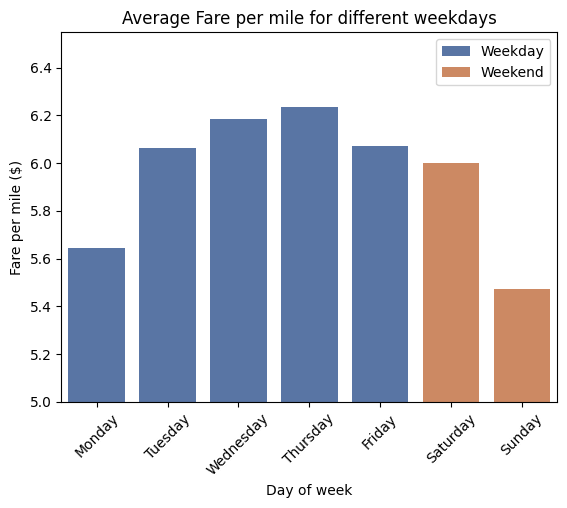

In [445]:
# Compare the average fare per mile for different days and for different times of the day

fare_per_mile_weekday = route_df.copy()
fare_per_mile_weekday = fare_per_mile_weekday.groupby(['pickup_weekday', 'pickup_weekend'], observed=True).agg({'fare_amount':'sum', 'trip_distance':'sum'}).reset_index()
fare_per_mile_weekday['fare_per_mile_weekday'] = fare_per_mile_weekday['fare_amount'] / fare_per_mile_weekday['trip_distance']
display(fare_per_mile_weekday)

sns.set_palette("deep")
ax = sns.barplot(data=fare_per_mile_weekday, x='pickup_weekday', y='fare_per_mile_weekday', hue='pickup_weekend')
ax.legend().set_title('')
plt.title('Average Fare per mile for different weekdays')
plt.ylabel('Fare per mile ($)')
plt.xlabel('Day of week')
ax.tick_params(axis='x', labelrotation=45)
ax.set(ylim=(5, None))
plt.show()

,pickup_hour,pickup_bin,fare_amount,trip_distance,fare_per_mile_hour
0,0,Early Morning,139932.950000,26125.890000,5.356103
1,1,Early Morning,87782.030000,16261.390000,5.398187
2,2,Early Morning,55429.030000,10039.740000,5.520963
3,3,Early Morning,38016.270000,7208.260000,5.273987
4,4,Early Morning,31590.600000,6514.180000,4.849513
5,5,Early Morning,35792.300000,7704.920000,4.645382
6,6,Morning,71984.540000,14698.070000,4.897550
7,7,Morning,121065.770000,21919.560000,5.523184
8,8,Morning,171333.140000,28579.190000,5.995031
9,9,Morning,195675.880000,32138.000000,6.088614


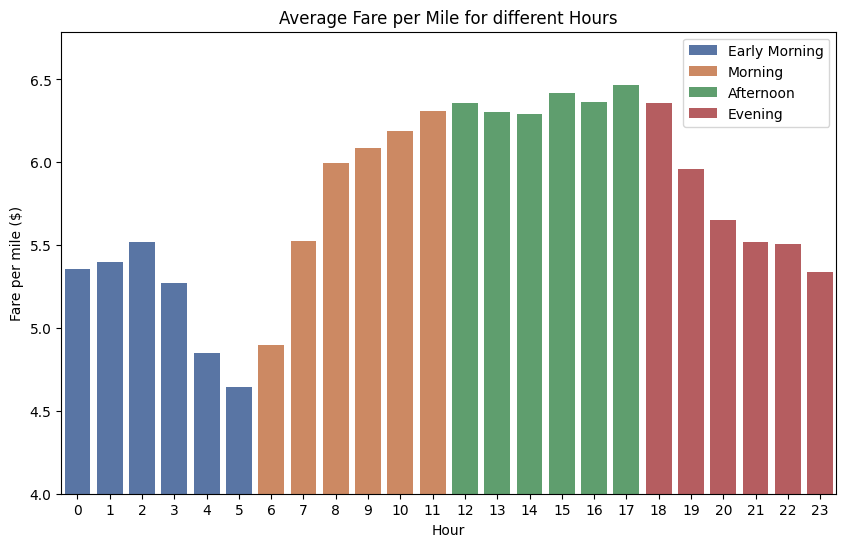

In [250]:
fare_per_mile_hour = route_df.copy()
fare_per_mile_hour = fare_per_mile_hour.groupby(['pickup_hour', 'pickup_bin'], observed=True).agg({'fare_amount':'sum', 'trip_distance':'sum'}).reset_index()
fare_per_mile_hour['fare_per_mile_hour'] = fare_per_mile_hour['fare_amount'] / fare_per_mile_hour['trip_distance']
display(fare_per_mile_hour)

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=fare_per_mile_hour, x='pickup_hour', y='fare_per_mile_hour', hue='pickup_bin')
plt.title('Average Fare per Mile for different Hours')
plt.ylabel('Fare per mile ($)')
plt.xlabel('Hour')
ax.legend().set_title('')
ax.set(ylim=(4, None))
plt.show()

**3.2.11** <font color = red>[3 marks]</font> <br>
Analyse the average fare per mile for the different vendors for different hours of the day

,Vendor,pickup_hour,fare_amount,trip_distance,fare_per_mile_hour_vendor
0,"Creative Mobile Technologies, LLC",0,30589.410000,5403.500000,5.661036
1,"Creative Mobile Technologies, LLC",1,18406.210000,3206.200000,5.740818
2,"Creative Mobile Technologies, LLC",2,12655.370000,2211.900000,5.721493
3,"Creative Mobile Technologies, LLC",3,7761.980000,1347.600000,5.759855
4,"Creative Mobile Technologies, LLC",4,7699.740000,1445.200000,5.327802
...,...,...,...,...,...
60,Myle Technologies Inc,16,304.570000,66.960000,4.548536
61,Myle Technologies Inc,17,188.980000,39.190000,4.822149
62,Myle Technologies Inc,18,120.170000,35.400000,3.394633
63,Myle Technologies Inc,19,55.650000,16.980000,3.277385


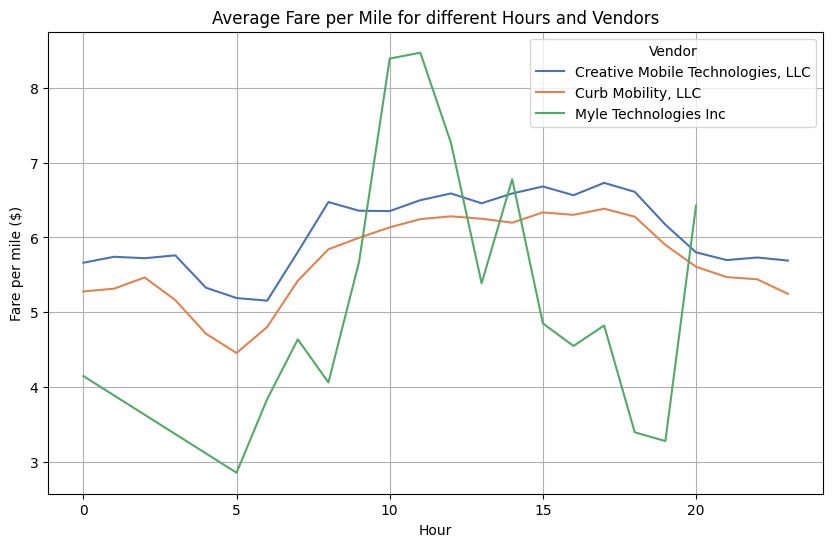

In [254]:
# Compare fare per mile for different vendors

fare_per_mile_hour_vendor = route_df.copy()
fare_per_mile_hour_vendor = fare_per_mile_hour_vendor.groupby(['Vendor', 'pickup_hour'], observed=True).agg({'fare_amount':'sum', 'trip_distance':'sum'}).reset_index()
fare_per_mile_hour_vendor['fare_per_mile_hour_vendor'] = fare_per_mile_hour_vendor['fare_amount'] / fare_per_mile_hour_vendor['trip_distance']

display(fare_per_mile_hour_vendor)

plt.figure(figsize=(10, 6))
ax = sns.lineplot(data=fare_per_mile_hour_vendor, x='pickup_hour', y='fare_per_mile_hour_vendor', hue='Vendor')
plt.title('Average Fare per Mile for different Hours and Vendors')
plt.ylabel('Fare per mile ($)')
plt.xlabel('Hour')
plt.grid(True)
plt.show()

**3.2.12** <font color = red>[5 marks]</font> <br>
Compare the fare rates of the different vendors in a tiered fashion. Analyse the average fare per mile for distances upto 2 miles. Analyse the fare per mile for distances from 2 to 5 miles. And then for distances more than 5 miles.


,Vendor,distance_tier,fare_amount,trip_distance,fare_per_mile_tier_vendor
0,"Creative Mobile Technologies, LLC",≤2 miles,390881.690000,44950.300000,8.695864
1,"Creative Mobile Technologies, LLC",2-5 miles,338980.600000,54257.200000,6.247661
2,"Creative Mobile Technologies, LLC",>5 miles,392727.750000,90982.200000,4.316534
3,"Curb Mobility, LLC",≤2 miles,1076744.500000,120985.220000,8.899802
4,"Curb Mobility, LLC",2-5 miles,1041473.230000,163204.350000,6.381406
5,"Curb Mobility, LLC",>5 miles,1386313.570000,318865.730000,4.347641
6,Myle Technologies Inc,2-5 miles,276.680000,37.910000,7.298338
7,Myle Technologies Inc,>5 miles,1564.350000,359.900000,4.346624


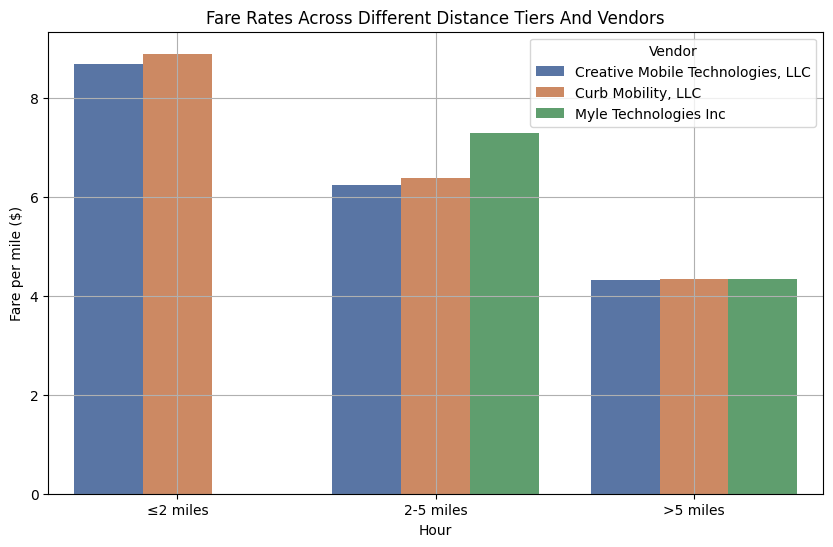

In [261]:
# Defining distance tiers

fare_per_mile_tier_vendor = route_df.copy()

fare_per_mile_tier_vendor['distance_tier'] = pd.cut(fare_per_mile_tier_vendor['trip_distance'], bins=[0, 2, 5, float('inf')],
                                 labels=['≤2 miles', '2-5 miles', '>5 miles'])


fare_per_mile_tier_vendor = fare_per_mile_tier_vendor.groupby(['Vendor', 'distance_tier'], observed=True).agg({'fare_amount':'sum', 'trip_distance':'sum'}).reset_index()
fare_per_mile_tier_vendor['fare_per_mile_tier_vendor'] = fare_per_mile_tier_vendor['fare_amount'] / fare_per_mile_tier_vendor['trip_distance']

display(fare_per_mile_tier_vendor)

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=fare_per_mile_tier_vendor, x='distance_tier', y='fare_per_mile_tier_vendor', hue='Vendor')
plt.title('Fare Rates Across Different Distance Tiers And Vendors')
plt.ylabel('Fare per mile ($)')
plt.xlabel('Hour')
plt.grid(True)
plt.show()

##### Customer Experience and Other Factors

**3.2.13** <font color = red>[5 marks]</font> <br>
Analyse average tip percentages based on trip distances, passenger counts and time of pickup. What factors lead to low tip percentages?

In [322]:
#  Analyze tip percentages based on distances, passenger counts and pickup times

tip_percentage = route_df.copy()

tip_percentage = tip_percentage.loc[tip_percentage['payment_label'] != 'Cash'] # We remove cash payment method as it doesn't have tip data
tip_percentage['tip_percentage_individual'] = tip_percentage['tip_amount'] / tip_percentage['fare_amount']
tip_percentage = tip_percentage[tip_percentage['tip_percentage_individual'] <= tip_percentage['tip_percentage_individual'].quantile(0.99)] # Remove extreme 1% tip outliers
tip_percentage.loc[tip_percentage['tip_percentage_individual'] > 0.25, 'tip_level'] = 'High'
tip_percentage.loc[tip_percentage['tip_percentage_individual'] < 0.1, 'tip_level'] = 'Low'
tip_percentage['miles_per_hour'] = tip_percentage['trip_distance'] / tip_percentage['trip_duration_minutes'] * 60

tip_percentage['distance_tier'] = pd.cut(tip_percentage['trip_distance'], bins=[0, 2, 5, float('inf')],
                                 labels=['≤2 miles', '2-5 miles', '>5 miles'])

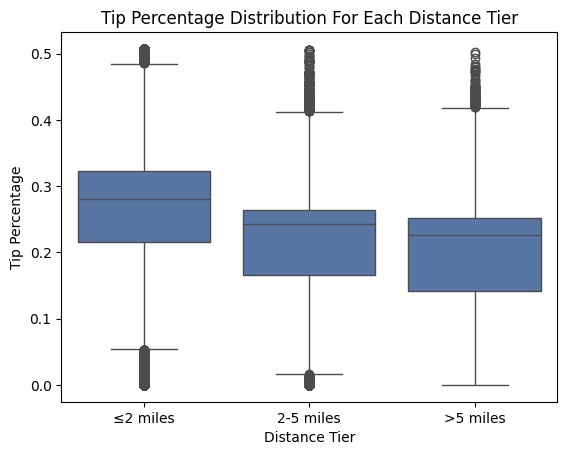

In [306]:
sns.boxplot(data=tip_percentage, x='distance_tier', y='tip_percentage_individual')
plt.title('Tip Percentage Distribution For Each Distance Tier')
plt.ylabel('Tip Percentage')
plt.xlabel('Distance Tier')
plt.show()

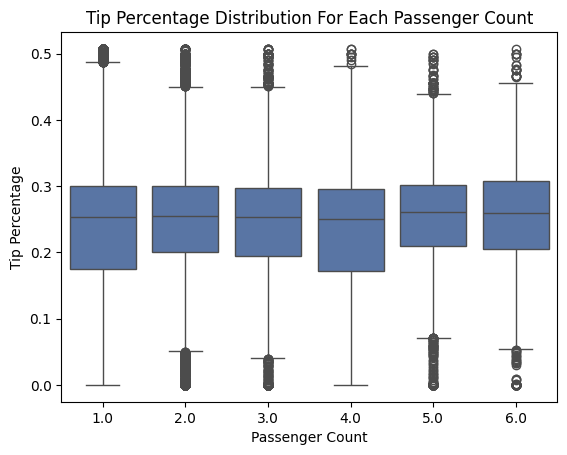

In [305]:
sns.boxplot(data=tip_percentage, x='passenger_count', y='tip_percentage_individual')
plt.title('Tip Percentage Distribution For Each Passenger Count')
plt.ylabel('Tip Percentage')
plt.xlabel('Passenger Count')
plt.show()

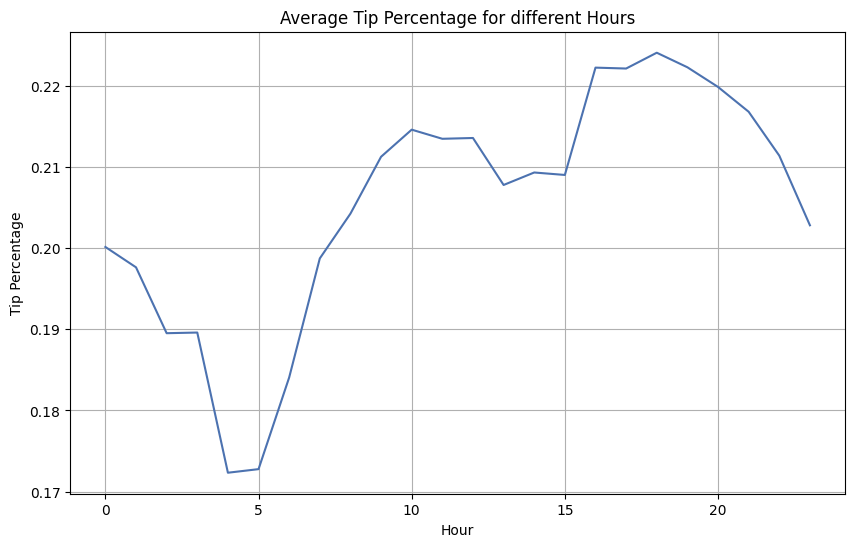

In [291]:
passenger_to_tip = tip_percentage.groupby(['pickup_hour']).agg({'tip_amount':'sum', 'fare_amount':'sum'}).reset_index()
passenger_to_tip['tip_percentage'] = passenger_to_tip['tip_amount'] / passenger_to_tip['fare_amount']

plt.figure(figsize=(10, 6))
ax = sns.lineplot(data=passenger_to_tip, x='pickup_hour', y='tip_percentage')
plt.title('Average Tip Percentage for different Hours')
plt.ylabel('Tip Percentage')
plt.xlabel('Hour')
plt.grid(True)
plt.show()

Additional analysis [optional]: Let's try comparing cases of low tips with cases of high tips to find out if we find a clear aspect that drives up the tipping behaviours

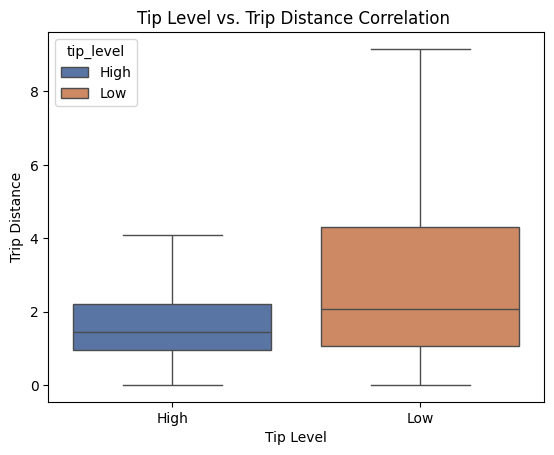

In [ ]:
# Compare trips with tip percentage < 10% to trips with tip percentage > 25%

sns.boxplot(data=tip_percentage, x='tip_level', y='trip_distance', hue='tip_level', showfliers=False)
plt.title('Tip Level vs. Trip Distance Correlation ')
plt.ylabel('Trip Distance')
plt.xlabel('Tip Level')
plt.show()

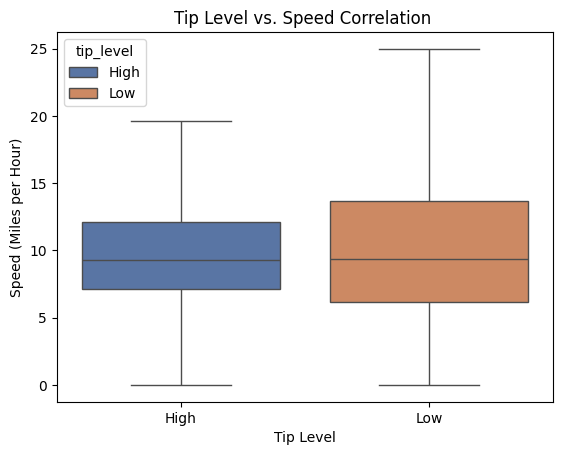

In [330]:
sns.boxplot(data=tip_percentage, x='tip_level', y='miles_per_hour', hue='tip_level', showfliers=False)
plt.title('Tip Level vs. Speed Correlation ')
plt.ylabel('Speed (Miles per Hour)')
plt.xlabel('Tip Level')
plt.show()

**3.2.14** <font color = red>[3 marks]</font> <br>
Analyse the variation of passenger count across hours and days of the week.

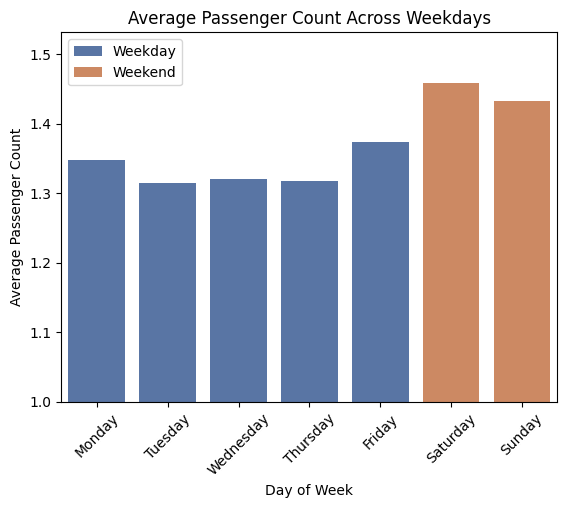

In [335]:
# See how passenger count varies across hours and days

passenger_count = route_df.copy()
passenger_count = passenger_count.groupby(['pickup_weekday', 'pickup_weekend'], observed=True)['passenger_count'].mean().reset_index()
passenger_count

ax = sns.barplot(data=passenger_count, x='pickup_weekday', y='passenger_count', hue='pickup_weekend')
ax.legend().set_title('')
plt.title('Average Passenger Count Across Weekdays')
plt.ylabel('Average Passenger Count')
plt.xlabel('Day of Week')
ax.tick_params(axis='x', labelrotation=45)
ax.set(ylim=(1, None))
plt.show()

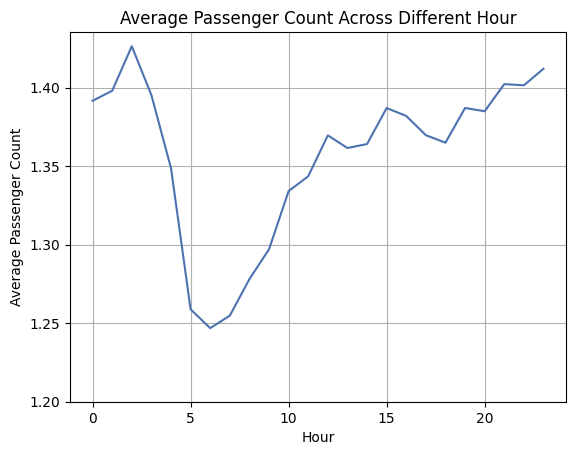

In [453]:
ax = sns.lineplot(data=route_df, x='pickup_hour', y='passenger_count', errorbar=None)
plt.grid(True)
plt.title('Average Passenger Count Across Different Hour')
plt.ylabel('Average Passenger Count')
plt.xlabel('Hour')
ax.set(ylim=(1.2, None))
plt.show()

**3.2.15** <font color = red>[2 marks]</font> <br>
Analyse the variation of passenger counts across zones

In [382]:
# How does passenger count vary across zones

location_average = zoned_df.groupby('LocationID').agg({'passenger_count':'mean', 'trip_distance':'count', 'extra':'mean'}).reset_index()
location_average = location_average.rename(columns={'trip_distance':'trip_count'})
zone_average = zones.merge(location_average, how='left', on='LocationID')

display(zone_average.sort_values('passenger_count', ascending=False)[['zone', 'passenger_count']].reset_index(drop=True).iloc[:10])


,zone,passenger_count
0,Saint Michaels Cemetery/Woodside,2.500000
1,Bronx Park,2.000000
2,College Point,2.000000
3,Oakland Gardens,2.000000
4,Jamaica Bay,2.000000
5,Battery Park,1.932203
6,Red Hook,1.800000
7,Flushing Meadows-Corona Park,1.658537
8,Bedford Park,1.625000
9,Chinatown,1.512195


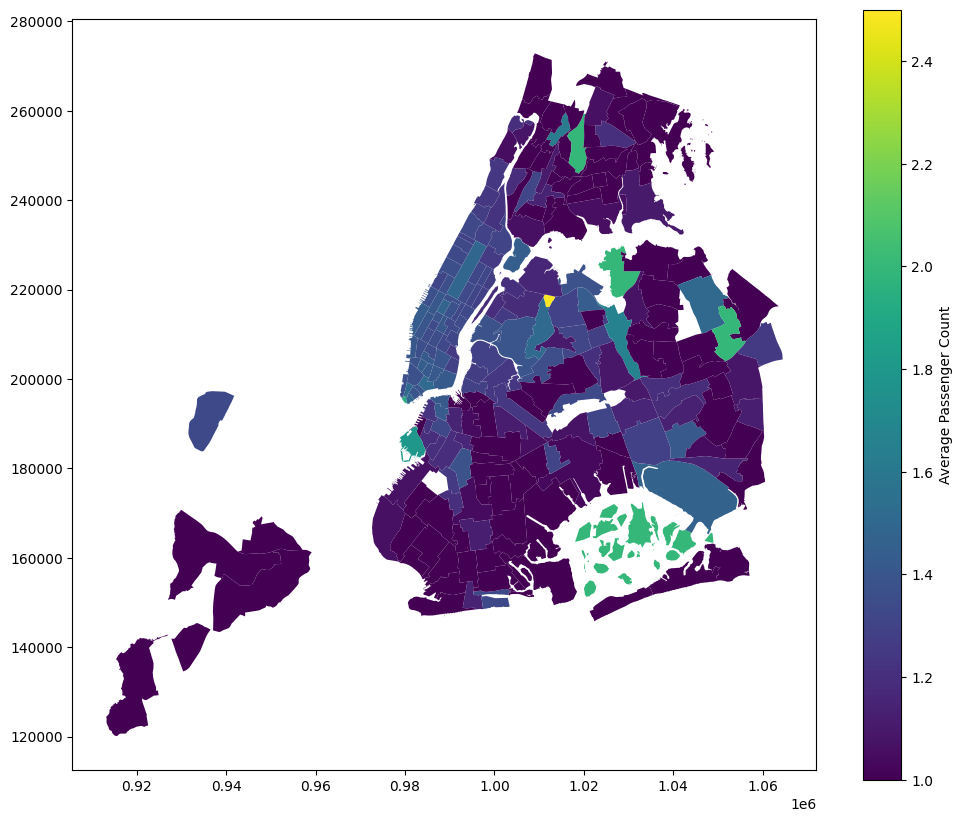

In [391]:
# For a more detailed analysis, we can use the zones_with_trips GeoDataFrame
# Create a new column for the average passenger count in each zone.

# Define figure and axis
fig, ax = plt.subplots(1, 1, figsize = (12, 10))


# Plot the map and display it
ax = zone_average.plot(
    column = 'passenger_count',
    ax = ax,
    legend = True,
    legend_kwds = {'label': "Average Passenger Count", 'orientation': "vertical"}
)
plt.show()


Find out how often surcharges/extra charges are applied to understand their prevalance

**3.2.16** <font color = red>[5 marks]</font> <br>
Analyse the pickup/dropoff zones or times when extra charges are applied more frequently

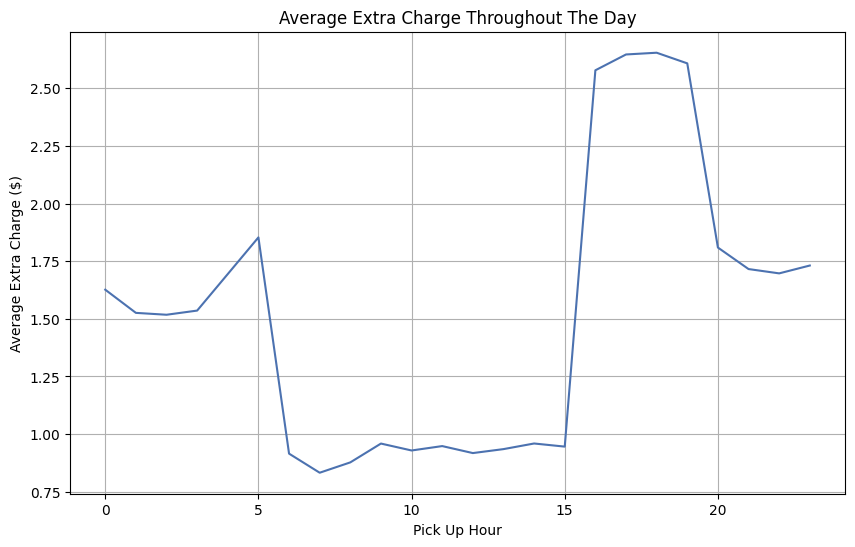

In [384]:
# How often is each surcharge applied?

plt.figure(figsize=(10, 6))
sns.lineplot(x='pickup_hour', y='extra', data=trip_fare_eda_df, errorbar=None)
plt.title('Average Extra Charge Throughout The Day')
plt.xlabel('Pick Up Hour')
plt.ylabel('Average Extra Charge ($)')
plt.grid(True)
plt.show()

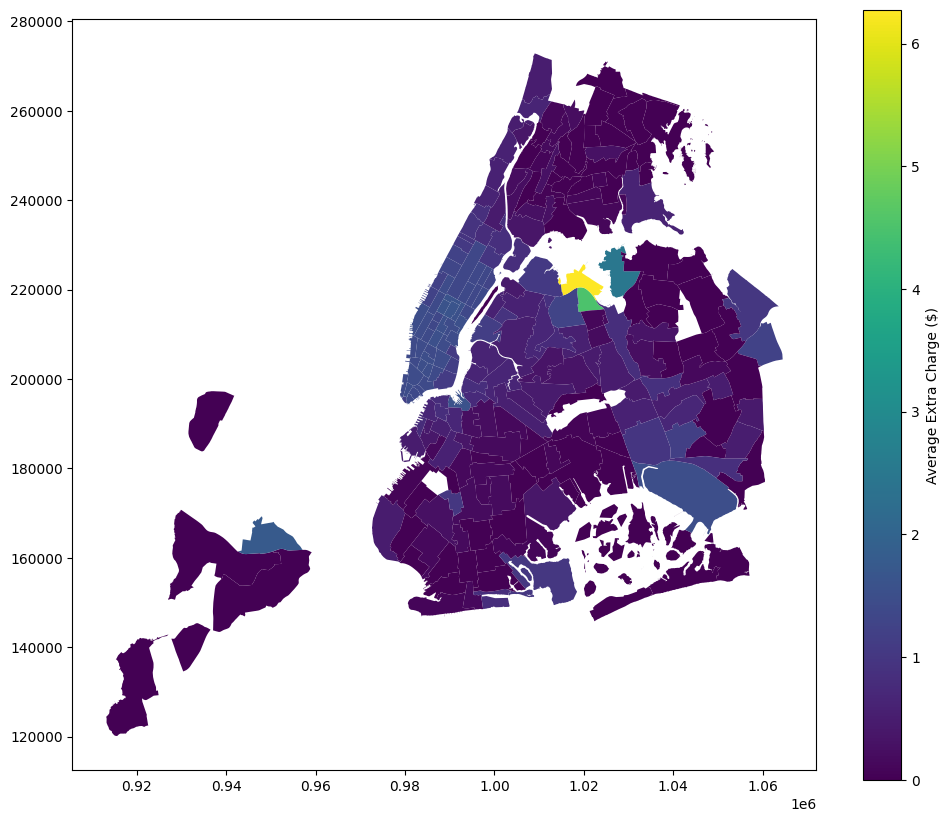

In [390]:
fig, ax = plt.subplots(1, 1, figsize = (12, 10))


# Plot the map and display it
ax = zone_average.plot(
    column = 'extra',
    ax = ax,
    legend = True,
    legend_kwds = {'label': "Average Extra Charge ($)", 'orientation': "vertical"}
)

plt.show()

## **4** Conclusion
<font color = red>[15 marks]</font> <br>

### **4.1** Final Insights and Recommendations
<font color = red>[15 marks]</font> <br>

Conclude your analyses here. Include all the outcomes you found based on the analysis.

Based on the insights, frame a concluding story explaining suitable parameters such as location, time of the day, day of the week etc. to be kept in mind while devising a strategy to meet customer demand and optimise supply.

**4.1.1** <font color = red>[5 marks]</font> <br>
Recommendations to optimize routing and dispatching based on demand patterns and operational inefficiencies

In [ ]:
# Demand-based routing: Utilize real-time data to predict demand spikes in busy areas and airport zones, optimizing routing to avoid congestion. 
# Implement dynamic dispatching systems that place cabs in high-demand zones during peak times, reducing idle time and increasing efficiency.

# Time-of-day scheduling: Adjust driver shifts to align with peak demand hours, focusing on commute times (8–10 AM, 5–7 PM) and nightlife hours (10 PM–2 AM). 
# This reduces the need for drivers to wait idle and increases the likelihood of quick, profitable fares.

**4.1.2** <font color = red>[5 marks]</font> <br>

Suggestions on strategically positioning cabs across different zones to make best use of insights uncovered by analysing trip trends across time, days and months.

**4.1.3** <font color = red>[5 marks]</font> <br>
Propose data-driven adjustments to the pricing strategy to maximize revenue while maintaining competitive rates with other vendors.